# Assignment 7 (Week 9)

>**Note**: 

```
- Late submissions are penalized.
- Only GitHub submissions are acceptable.
- Remember to read the `instructions` carefully.
```

## Name: Enter Your Name: **UCHECHUKUKA EDGAR**

<br>

## Please show and display ALL your calculations and results.


## **Importing Libraries**

In [149]:
# Built-in library
import itertools
import re
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 1_000


# Black code formatter (Optional)
#%load_ext lab_black

In [150]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from textblob import TextBlob
from textblob import Word
from textblob.sentiments import NaiveBayesAnalyzer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS


In [151]:
from sklearn.feature_extraction.text  import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler



## **Functions**

In [152]:
# a function that loads in the data
def load_data(*, 
              filename: str,
              sep: str = ","
)-> pd.DataFrame:
    """ This is used to load the data.
    Params;
         filename (str): The filepath.
         sep (str, default = ","): The separator. Examples of separators; ",","\t", etc 
    Returns;
         data (pd.DataFrame): The loaded dataframe.
    """
    Data = pd.read_csv(filename, sep = sep)
    print(f"Shape of data: {Data.shape}\n")
    return Data

In [153]:
# a function that returns unique values of specified feature

def unique_values(*,
                    data : pd.DataFrame,
                    feature: str
)-> pd.DataFrame:
    """ This function returns the unique values of specified variables.
    Params;
          data (Pandas DF): The source DataFrame containing the variable.
          feature (str) : The specified variable
    Returns;
          Unique values of variable
   """

    data = data.copy()
    result = data[f"{feature}"].unique()
    return result


In [154]:
# a function to return the count of specified feature
def feature_counts(*,
                   data: pd.DataFrame,
                   feature: str
)-> pd.DataFrame:
    """ This function returns the value counts of variables.
    Params;
          data (Pandas DF): The source DataFrame containing the variable.
          feature (str): The variable to count.
    Returns;
          A value count of the variable
   """
    data = data.copy()

    result = data[f"{feature}"].value_counts()
    result = (
        pd.DataFrame(result)
        .reset_index()
        .rename(columns = {"index": (f"{feature}"), (f"{feature}"): "Count"})
    )

    return result


In [155]:
# a function to show plot count
def plot_counts(*,
                data: pd.DataFrame,
                features: list[str],
                n_rows: int,
                n_cols: int,
                figsize: tuple = (15, 8),
)-> "plot":
    """This returns a plot count of all specified features.
    Params;
         data (Pandas DF): The source DataFrame containing the variable.
         features (list[str]): The variable to view
         n_rows (int): The desired number of rows for the subplot.
         n_cols (int): The desired number of columns for the subplot.
         figsize(tuple): The desired figure size of plot
    Returns;
          A plot count of specified features.
    """
    fig, axs = plt.subplots(n_rows, n_cols, figsize = figsize)
    for idx, feat in enumerate(features):
            if n_rows > 1:
               ax = axs[(idx // n_cols), (idx % n_cols)]
            else:
               ax = axs[idx]

            sns.countplot(data = data, x = feat, ax = ax)
            ax.set_title(f"Count Plot of {feat}")

            labels = sorted(data[feat].value_counts().index)
            ax.tick_params(axis = "x", rotation = 80)


      # annotate the chart
            for bar in ax.patches:
                x_val = bar.get_x() + bar.get_width() / 2  # x pos
                y_val = bar.get_height()  # y pos
                ax.annotate(
                    text = y_val, # text pos
                    xy = (x_val, y_val), # (x, y)
                    xytext = (0, 6), # text position
                    ha = "center", # horizontal alignment
                    va = "center", # vertical alignment
                    size = 15,  # text size
                    textcoords = "offset points",
                )


    fig.tight_layout()
    plt.show()

In [156]:
# a function that converts one label to another label
def convert_label(*,
                  data : pd.DataFrame,
                  feature: str,
                  label : str,
                  replace_value : str
)-> pd.DataFrame:
    """ This function replaces one label in a specified column to another label.
    Params;
         data (Pandas DF) : The source DataFrame containing the variable.
         feature (str) : The specified variable.
         label (list[str]) :  A list of labels to be converted.
         replaced_value (str) : The label to be replaced with.
    Returns;
          Converted label
    """
    data[f"{feature}"] = np.where(data[f"{feature}"] == label, replace_value, data[f"{feature}"])
    return data[f"{feature}"].value_counts()

In [157]:
# A function that bins a specified feature using Domain knowledge
def feature_bin(*,
                data: pd.DataFrame,
                feature : str,
                choicelist: list[str],
                val_1 : int,
                a : int,
                b : int,
                c : int
)-> pd.DataFrame:
    """ This function groups the labels of a specified feature into desired numbers.
    Params;
        data (Pandas DF) : The source DataFrame containing the variable.
        feature (str) : The specified variable.
        choicelist (list[str]) : A list of labels for the respective condlist.
        val_1 (int) : The value for the first label.
        a (int) : The first value in the range in the second label.
        b (int) : The second value in the range in the second label.
        c (int) : The value for the third label.
    Returns;
         A regrouped label of the specified feature.
    """
    data[f"{feature}"].value_counts()
    condlist = [(data[f"{feature}"] == val_1), (data[f"{feature}"].isin(range(a, b))), (data[f"{feature}"] > c)]
    data[f"{feature}_binned"] = np.select(condlist=condlist, choicelist=choicelist)
    return data[[f"{feature}", f"{feature}_binned"]].sample(n = 10, random_state = 1177)


In [158]:
# A function that converts contraction words to their expansion form
def cont_to_expd(val):
  """This function turns contraction words to their expansion form.
     Params;
          val(str) : The sentence or group of words to be expanded.
     Returns;
           The expansion form of the word.
  """
  if type(val) is str:
    val = val.replace("\\", "")
    for key in contractions:
      value = contractions[key]
      val = val.replace (key, value)
    return val
  else:
    return val

In [159]:
# a function that plots histogram
def plot_histogram(*, data: pd.DataFrame, feature: str, figsize: tuple = (15, 8), text: str = "",
) -> "Plot":
    """This returns a Seaborn Histogram.
    Params;
         data (Pandas DF): The source DataFrame containing the variable.
         features (str): The variable to view.
         text (str): Title of the Histogram.
    Returns;
          A Histogram of the specified Variable
    """
    
    sns.histplot(data=data, x=feature)
    plt.title(f"Distribution of {feature!r} {text}", size=16)
    plt.tight_layout()
    plt.show()

In [160]:
# A function that shows the plot of word frequency of words or group of words in the Review_Text
def word_gram(*,
              data : pd.DataFrame,
              feature : str,
              a : int,
              b : int,
              n : int,
              figsize : tuple,
              gram_type : str,
              Frequency : str,
)-> "Plot":
    """ This function counts the frequency of words or a group of words in a specified feature
    and returns a plot of the desired numbers (n).
       Params;
             data(Pandas DF): The source DataFrame containing the variable.
             feature(str) : The desired variable to view.
             a(int) : The number of word/words to view.
             b(int) : The number of word/words to view.
             figsize(tuple) : The desired figure size of the plot.
             gram_type(str) : Type of gram to plot e.g unigram, bigram, trigram.
             Frequency(str) : The count.
       Returns;
             A plot of words (or group of words) showing their frequency count in the specified feature.
    """
    x = data[f"{feature}"]
    vec = CountVectorizer (ngram_range = (a, b), stop_words = "english").fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted (words_freq, key = lambda x : x[1], reverse = True)
    words_freq[:n]
    words = words_freq[:n]
    gram = pd.DataFrame (words, columns = [gram_type, Frequency])
    gram_plot = gram.set_index(gram_type)
    sns.barplot(x = gram_type, y = Frequency, data = gram)
    plt.xlabel(gram_type, size = 14)
    plt.ylabel (Frequency, size = 14)
    plt.tick_params(axis = "x", rotation = 80)
    plt.title(f"Top 20 {gram_type} Words", size = 16)

    plt.tight_layout
    plt.show()

In [161]:
# A function that returns the average length of words in a text
def avg_word_length(x):
  """This returns the average length of words in a text. """
  words = x.split()
  word_len = 0
  for word in words:
    word_len = word_len + len(word)

  return word_len/len(words)

In [162]:
# A function that shows the wordcloud of a specified feature
def my_wordcloud(*,
                  data: pd.DataFrame,
                  feature: str,
                  variable: str,
                  Text_var : str,
                  color : str,
) -> "image":
      """ This functions shows a wordcloud of a specified feature.
        Params;
             data (Pandas DF): The source DataFrame containing the variable.
             feature (str): The feature to view.
             Variable (str): The specified variable in the feature.
             Text_var (str): The text used to create the wordcloud.
             color (str): The desired background color.
        Returns;
             A wordcloud of the desired feature.
      """
      wordcloud = WordCloud(
        width = 1000,
        height = 200,
        margin = 2,
        scale = 3,
        max_words = 200,
        min_font_size = 7,
        stopwords = STOPWORDS,
        random_state = 15,
        background_color = color,
        mode = "RGB",
        normalize_plurals = True,
        contour_color = "white",
        repeat = False
    )
      filt = (data[f"{feature}"] == variable)
      wordcl = data.loc[filt, Text_var]
      text_inp = wordcl
      textcon = " ".join(text_inp)
      wordcloud = wordcloud.generate(textcon)
      image = wordcloud.to_image()
      image = np.array(image)
      image = image.astype(np.float32)
      img = Image.fromarray(np.uint8(image))
      img.show()



In [163]:
# A function that bins a feature for sentiment analysis using Domain knowledge
def sent_feature_bin(*,
                data: pd.DataFrame,
                feature : str,
                choicelist: list[str],
                a : int,
                b : int,
                c : int
)-> pd.DataFrame:
    """ This function groups the labels of a specified feature into desired numbers.
    Params;
        data (Pandas DF) : The source DataFrame containing the variable.
        feature (str) : The specified variable.
        choicelist (list[str]) : A list of labels for the respective condlist.
        val_1 (int) : The value for the first label.
        a (int) : The first value in the range in the second label.
        b (int) : The second value in the range in the second label.
        c (int) : The value for the third label.
    Returns;
         A regrouped label of the specified feature.
    """
    data[f"{feature}"].value_counts()
    condlist = [(data[f"{feature}"].isin(range(a, b))), (data[f"{feature}"] < c)]
    data[f"{feature}_binned"] = np.select(condlist=condlist, choicelist=choicelist)
    return data[[f"{feature}", f"{feature}_binned"]].sample(n = 10, random_state = 1177)


## **Load Data**

In [164]:
sc_rev = load_data(filename = "Ulta Skincare Reviews.csv", sep = ",")
sc_rev.head()

Shape of data: (4150, 10)



Review_Title  \
0                          Perfect   
1                    You need this   
2                       Clean skin   
3                 Love This Stuff!   
4  This exfoliates very nicely and   

                                                                                                                                                                                                                                  Review_Text  \
0                                                                                                                                                     Love using this on my face while in the shower. Heats up and gives a light scrub nicely   
1                                                                                                                                                          Even better than the daily microfoliant. I'm obsessed. My skin is SO MUCH smoother   
2                                                                                                                                                               Enjoy this product so much ! I look forward to using it - really feels great.   
3  I've never tried anything like this before and I love it. When you apply it to your face you get a little shot of warm that feels so good. The scrub seems very gritty but the only side effects I've encountered have been positive ones.   
4                                                                               This exfoliates very nicely and gives a very smooth skin after with no irritation and no reaction to the skin . I highly recommended it, i will buy it again.   

  Verified_Buyer   Review_Date Review_Location  Review_Upvotes  \
0             No   15 days ago     Undisclosed               0   
1             No   27 days ago     Undisclosed               0   
2             No  2 months ago     Undisclosed               0   
3             No  2 months ago     Undisclosed               0   
4             No  2 months ago     Undisclosed               0   

   Review_Downvotes                      Product        Brand Scrape_Date  
0                 0  Multi-Vitamin Thermafoliant  Dermalogica     3/27/23  
1                 0  Multi-Vitamin Thermafoliant  Dermalogica     3/27/23  
2                 0  Multi-Vitamin Thermafoliant  Dermalogica     3/27/23  
3                 0  Multi-Vitamin Thermafoliant  Dermalogica     3/27/23  
4                 0  Multi-Vitamin Thermafoliant  Dermalogica     3/27/23

This data consists of **4150** rows and **10** columns

## **Data Information**

In [165]:
# columns datatype
sc_rev.dtypes

Review_Title        object
Review_Text         object
Verified_Buyer      object
Review_Date         object
Review_Location     object
Review_Upvotes       int64
Review_Downvotes     int64
Product             object
Brand               object
Scrape_Date         object
dtype: object

The data is made up of **2** interger dtype columns and **8** object dtype columns.

In [166]:
# check for duplicate values
sc_rev.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
4145    False
4146    False
4147    False
4148    False
4149    False
Length: 4150, dtype: bool

No duplicate rows can be found in the data.

In [167]:
# check for missing values
sc_rev.isna().sum()

Review_Title        0
Review_Text         2
Verified_Buyer      0
Review_Date         0
Review_Location     1
Review_Upvotes      0
Review_Downvotes    0
Product             0
Brand               0
Scrape_Date         0
dtype: int64

**There are two missing values in Review_Text and one missing value in Review_Location. These values would be dropped since they are so little.**

In [168]:
# Drop missing values
new_rev = sc_rev.copy()
new_rev = new_rev.dropna(how='any').dropna(how='any', axis=1)

In [169]:
# verify (i.e before dropping and after dropping)
sc_rev.shape, new_rev.shape

((4150, 10), (4147, 10))

#### **Unique Values of Variables**

In [170]:
# Unique values of Scrape Date
unique_values(data = sc_rev, feature = "Scrape_Date")


array(['3/27/23'], dtype=object)

In [171]:
# Unique values of Review_Location
unique_values(data = sc_rev, feature = "Review_Location")


array(['Undisclosed', 'Verified Buyer', 'PA', ..., 'vernon hills, il',
       'Humboldt, CA', 'Fayetteville'], dtype=object)

In [172]:
# Unique values of Review_Date
unique_values(data = sc_rev, feature = "Review_Date")


array(['15 days ago', '27 days ago', '2 months ago', '3 months ago',
       '4 months ago', '5 months ago', '6 months ago', '7 months ago',
       '8 months ago', '9 months ago', '10 months ago', '11 months ago',
       '1 year ago', '2 years ago', '3 years ago', '4 years ago',
       '5 years ago', '6 years ago', '7 years ago', '8 years ago',
       '9 years ago', '10 years ago', '11 years ago', '1 month ago',
       '7 days ago', '16 days ago', '17 days ago', '18 days ago',
       '19 days ago', '20 days ago', '22 days ago', '23 days ago',
       '25 days ago', '28 days ago', '29 days ago', '4 days ago',
       '5 days ago', '12 days ago', '14 days ago', '21 days ago',
       '24 days ago'], dtype=object)

In [173]:
# Unique values of Product
unique_values(data = sc_rev, feature = "Product")


array(['Multi-Vitamin Thermafoliant', 'Hydro Masque Exfoliant',
       'Daily Superfoliant', 'Daily Microfoliant'], dtype=object)

In [174]:
# Unique values of Brand
unique_values(data = sc_rev, feature = "Brand")


array(['Dermalogica'], dtype=object)

In [175]:
# Unique values of Review_Upvotes
unique_values(data = sc_rev, feature = "Review_Upvotes")


array([ 0,  3,  1,  2, 20,  4,  7,  5,  8, 11,  6,  9, 25, 14, 12, 17, 15,
       13, 10, 16, 19, 47, 84])

In [176]:
# Unique values of Review_Downvotes
unique_values(data = sc_rev, feature = "Review_Downvotes")


array([ 0,  1,  3,  7,  9,  2,  4,  6, 11,  8,  5, 13, 14, 35, 10])

**Because all rows have the same "Brand" and "Scrape_Date," these two columns will be removed. The "Review_Title" will also be eliminated because the "Review_text" contains more information than the "Review_Title."**


In [177]:
# Drop columns
var_to_drop = ["Brand", "Scrape_Date", "Review_Title"]
new_rev.drop(columns = var_to_drop, inplace = True)

In [178]:
# verify
new_rev.columns

Index(['Review_Text', 'Verified_Buyer', 'Review_Date', 'Review_Location',
       'Review_Upvotes', 'Review_Downvotes', 'Product'],
      dtype='object')

> Data source is from **Kaggle**. To complete this assignment, you **must create an account** with **Kaggle**.

- The data can be found [here](https://www.kaggle.com/datasets/nenamalikah/nlp-ulta-skincare-reviews).

### Data Dictionary

```
- Review Title: The title of the review.
- Review_Text: The full text of the review.
- Verified_Buyer: Whether the reviewer is a verified buyer of the product.
- Review_Date: The date the review was published relative to the review scrape date.
- Review_Location: The location of the reviewer.
- Review_Upvotes: How many times the review was upvoted by other reviewers.
- Review_Downvotes: How many times the review was downvoted by other reviewers.
- Product: The name of the product the review was issued for.
- Brand: The brand of the product.
- Scrape Date: The date the data was pulled from the web.
```

### Objectives

```
1. Exploratory Data Analysis.

2. Research and experimentation.

3. Sentiments Analysis.

```

## Note: 

- The assignment **should** be submitted through a `public` GitHub repository.

<br><hr>

###  Qs 1. Explore the data. What can the reviews tell us about the products? Do most buyers have common skincare issues? What issues did the products help solve or exacerbate?


## **Data Exploration**

In [179]:
# Value count of Review_Location
feature_counts(data = new_rev, feature = "Review_Location")

Review_Location  Count
0         Undisclosed    909
1         Los Angeles    117
2                Iowa     93
3         Richmond Va     89
4         Orlando, Fl     89
...               ...    ...
1418            Devon      1
1419  Southend-On-Sea      1
1420   United Kingdom      1
1421        Leicester      1
1422     Fayetteville      1

[1423 rows x 2 columns]

In [180]:
# Value count of Review_Date
feature_counts(data = new_rev, feature = "Review_Date")

Review_Date  Count
0     2 years ago    915
1      1 year ago    844
2     5 years ago    638
3     4 years ago    410
4     3 years ago    279
5    5 months ago    234
6     6 years ago    201
7     7 years ago     94
8    6 months ago     62
9    9 months ago     55
10   3 months ago     46
11   4 months ago     46
12   2 months ago     43
13   7 months ago     42
14  10 months ago     42
15  11 months ago     42
16   8 months ago     40
17    9 years ago     24
18    1 month ago     23
19   11 years ago     16
20    8 years ago     11
21   10 years ago     11
22    23 days ago      3
23    16 days ago      3
24    17 days ago      3
25    29 days ago      2
26    25 days ago      2
27    15 days ago      2
28    18 days ago      2
29    19 days ago      1
30    20 days ago      1
31    22 days ago      1
32     7 days ago      1
33    28 days ago      1
34    27 days ago      1
35     4 days ago      1
36     5 days ago      1
37    12 days ago      1
38    14 days ago      1
39    21 days ago      1
40    24 days ago      1

In [181]:
# Value count of Product
feature_counts(data = new_rev, feature = "Product")

Product  Count
0           Daily Superfoliant   1500
1           Daily Microfoliant   1497
2       Hydro Masque Exfoliant    800
3  Multi-Vitamin Thermafoliant    350

In [182]:
# Value count of Product
feature_counts(data = new_rev, feature = "Verified_Buyer")

Verified_Buyer  Count
0             No   2900
1            Yes   1247

In [183]:
# Value count of Product
feature_counts(data = new_rev, feature = "Review_Upvotes")

Review_Upvotes  Count
0                0   3146
1                1    542
2                2    218
3                3     89
4                4     48
5                5     29
6                7     16
7                6     11
8                9      9
9               12      6
10               8      5
11              14      5
12              10      5
13              11      4
14              13      4
15              25      2
16              15      2
17              20      1
18              17      1
19              16      1
20              19      1
21              47      1
22              84      1

In [184]:
# Value count of Product
feature_counts(data = new_rev, feature = "Review_Downvotes")

Review_Downvotes  Count
0                  0   3782
1                  1    262
2                  2     54
3                  3     19
4                  4      7
5                  7      6
6                  9      6
7                  5      3
8                  6      2
9                 11      1
10                 8      1
11                13      1
12                14      1
13                35      1
14                10      1

**The above value counts of each feature are represented graphically in the plot count below.**

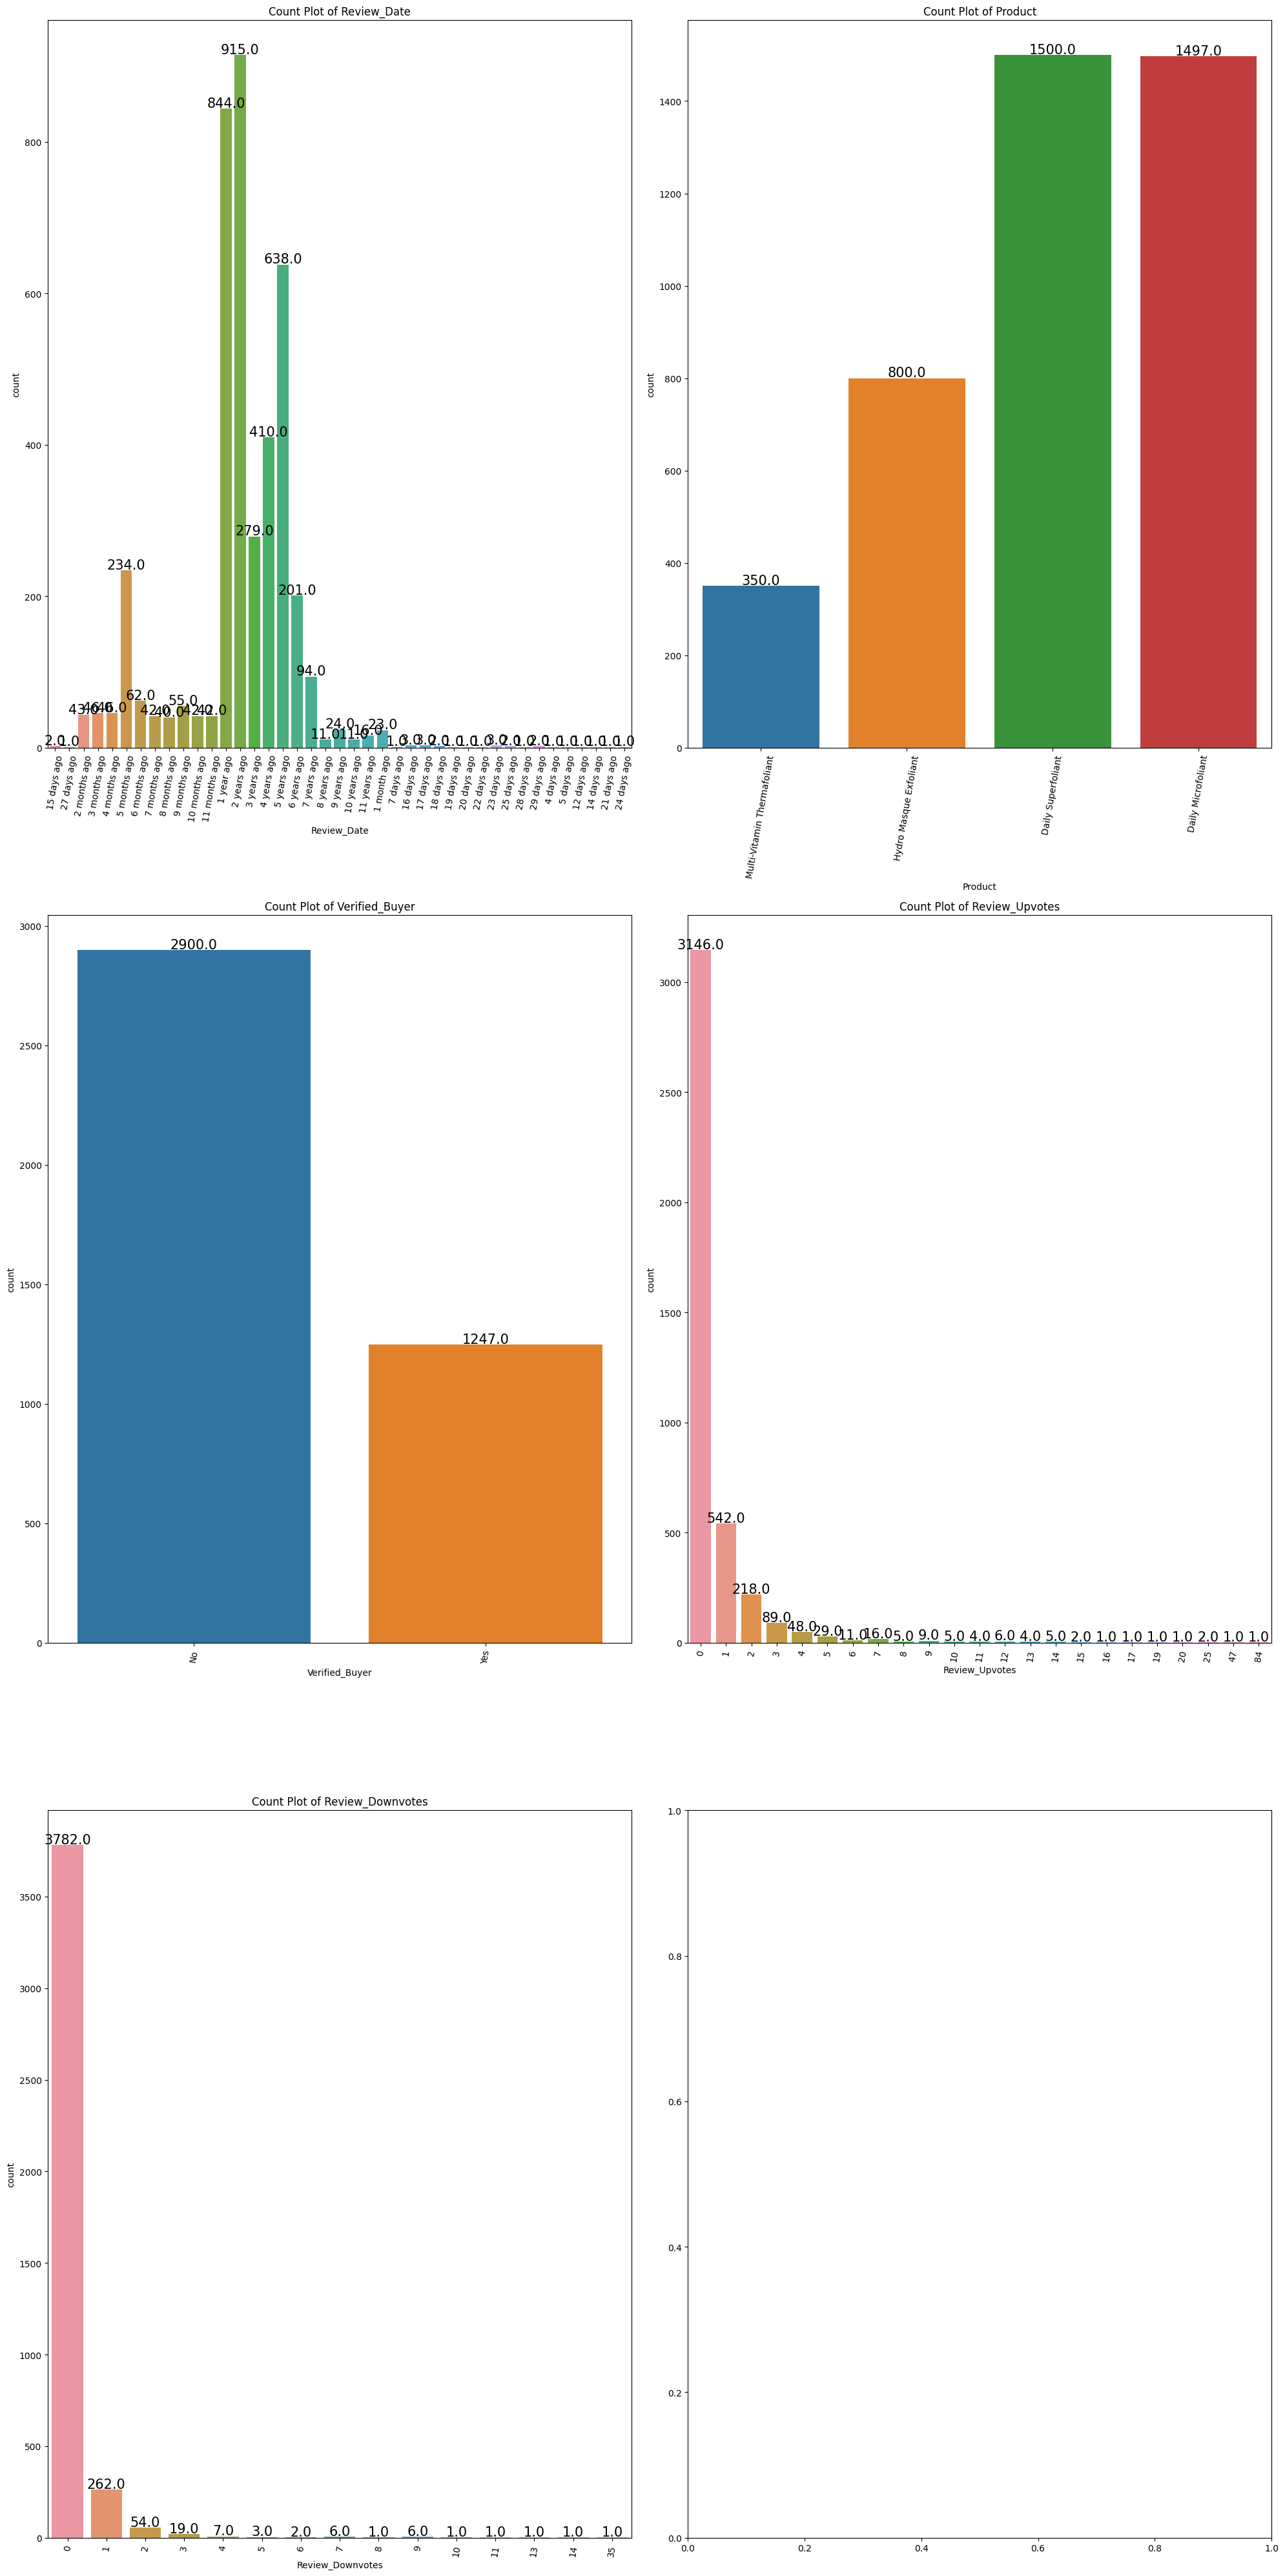

In [185]:
# plot counts of variables
feats = [ "Review_Date", "Product", "Verified_Buyer", "Review_Upvotes", "Review_Downvotes"]
plot_counts(
    data=new_rev, features=feats, n_rows=3, n_cols=2, figsize=(20, 40)
)

It is seen from the above that the highest numbers from each feature are;<br>
<br>Review_Location - Undisclosed (909)<br>
**Interprets that of all the consumers, 909 did not disclose their locations**.

<br> Review_Date - 2 years ago (915)<br>
**Interprets that the highest number of reviews were given 2 years ago.**

<br> Product - Daily Superfoliant (1500)<br>
**Interprets that the product mostly reviewed by the onsumers is the Daily Superfoliant**.

<br> Verified_Buyer - No (2900) <br>
**Interprets that a highter number of the consumers who made a review are not verified buyers**.

<br> Review_Upvotes - 0 (3146)<br>
<br> Review_Downvotes 0 (3782)<br>
**Interprets that majority of the reviews made were neither upvoted for nor downvoted for.**


### **Label Binning**

As observed in the value counts above, some features contain rare labels, hence those labels are regrouped with other labels.


In [186]:
# Merge 6 years ago with 5 years ago
convert_label(data = new_rev, feature = "Review_Date", label = "6 years ago", replace_value = "5 years ago").head()

2 years ago    915
1 year ago     844
5 years ago    839
4 years ago    410
3 years ago    279
Name: Review_Date, dtype: int64

In [187]:
# Merge 7 years ago with 5 years ago
convert_label(data = new_rev, feature = "Review_Date", label = "7 years ago", replace_value = "5 years ago").head()

5 years ago    933
2 years ago    915
1 year ago     844
4 years ago    410
3 years ago    279
Name: Review_Date, dtype: int64

In [188]:
# Merge 8 years ago with 5 years ago
convert_label(data = new_rev, feature = "Review_Date", label = "8 years ago", replace_value = "5 years ago").head()

5 years ago    944
2 years ago    915
1 year ago     844
4 years ago    410
3 years ago    279
Name: Review_Date, dtype: int64

In [189]:
# Merge 9 years ago with 5 years ago
convert_label(data = new_rev, feature = "Review_Date", label = "9 years ago", replace_value = "5 years ago").head()

5 years ago    968
2 years ago    915
1 year ago     844
4 years ago    410
3 years ago    279
Name: Review_Date, dtype: int64

In [190]:
# Merge 10 years ago with 5 years ago
convert_label(data = new_rev, feature = "Review_Date", label = "10 years ago", replace_value = "5 years ago").head()

5 years ago    979
2 years ago    915
1 year ago     844
4 years ago    410
3 years ago    279
Name: Review_Date, dtype: int64

In [191]:
# Rename the "5 years ago" label to "5 years ago and & above"
new_rev["Review_Date" ] = new_rev["Review_Date"].str.replace("5 years ago", "5 years ago & Above")

# Verify
new_rev["Review_Date" ].value_counts().head(1)

5 years ago & Above    979
Name: Review_Date, dtype: int64

In [192]:
# Bin
new_rev['Review_Date_grp'] = np.where(new_rev['Review_Date'].isin(['1 year ago', '2 years ago', "3 years ago", "4 years ago", "5 years ago & Above"]),
                           new_rev['Review_Date'].str.title(),
                           'Less than a year')

# Verify
new_rev["Review_Date_grp"].value_counts()

5 Years Ago & Above    979
2 Years Ago            915
1 Year Ago             844
Less than a year       720
4 Years Ago            410
3 Years Ago            279
Name: Review_Date_grp, dtype: int64

**The Review_Date feature has been regrouped, such that reviews from 5 years & above are in same group, reviews from less than a year are in same group, while the rest are still the same.**

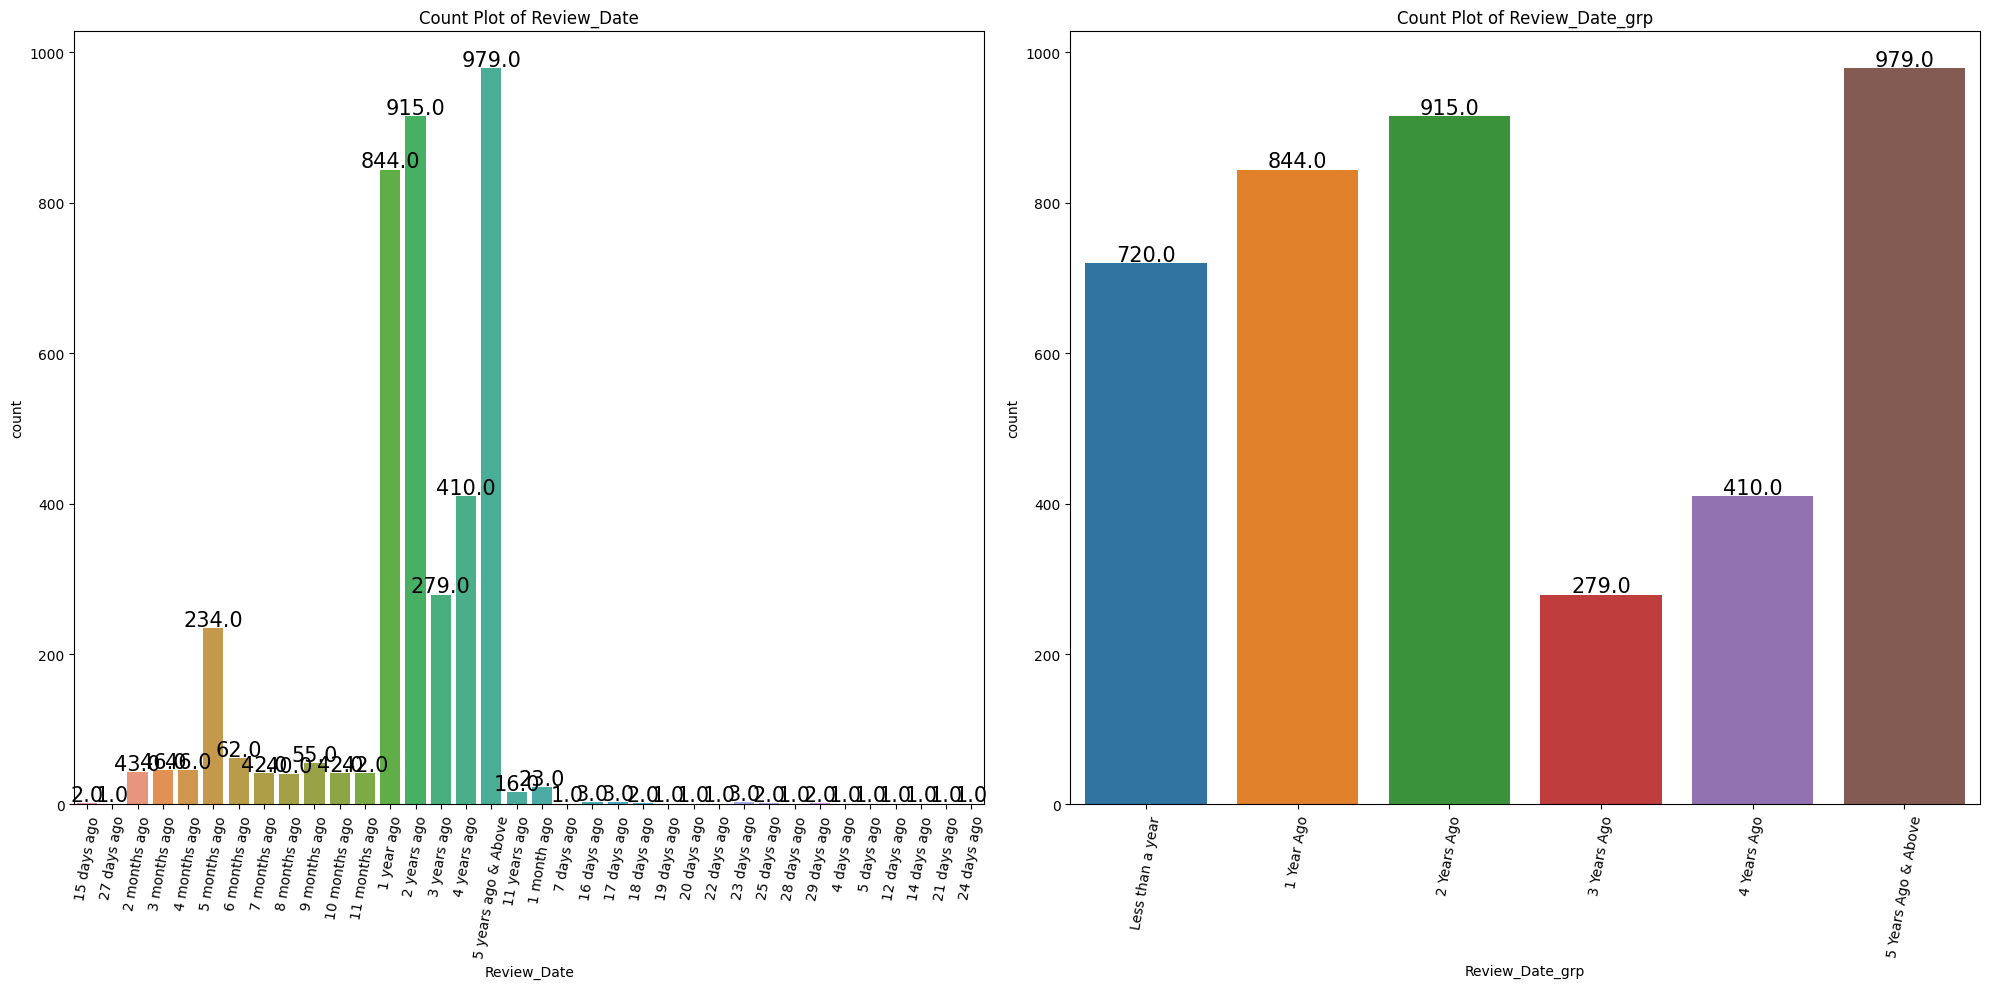

In [193]:
# Comparing plot count for Review_Date before and after binning
feats = [ "Review_Date", "Review_Date_grp"]
plot_counts(
    data=new_rev, features=feats, n_rows=1, n_cols=2, figsize=(20, 10)
)

##### **Review_Upvotes**

In [194]:
# Grouping the Review_upvotes into three
feature_bin (data = new_rev, feature = "Review_Upvotes", choicelist = ["0", "1 to 6", "> 6"], val_1 = 0, a = 1, b = 7, c = 6)

Review_Upvotes Review_Upvotes_binned
2802               0                     0
868                0                     0
3824               1                1 to 6
1552               0                     0
185                0                     0
114                0                     0
4027               0                     0
2519               0                     0
624                0                     0
3631               0                     0

In [195]:
# Verify
new_rev["Review_Upvotes_binned"].value_counts()

0         3146
1 to 6     937
> 6         64
Name: Review_Upvotes_binned, dtype: int64

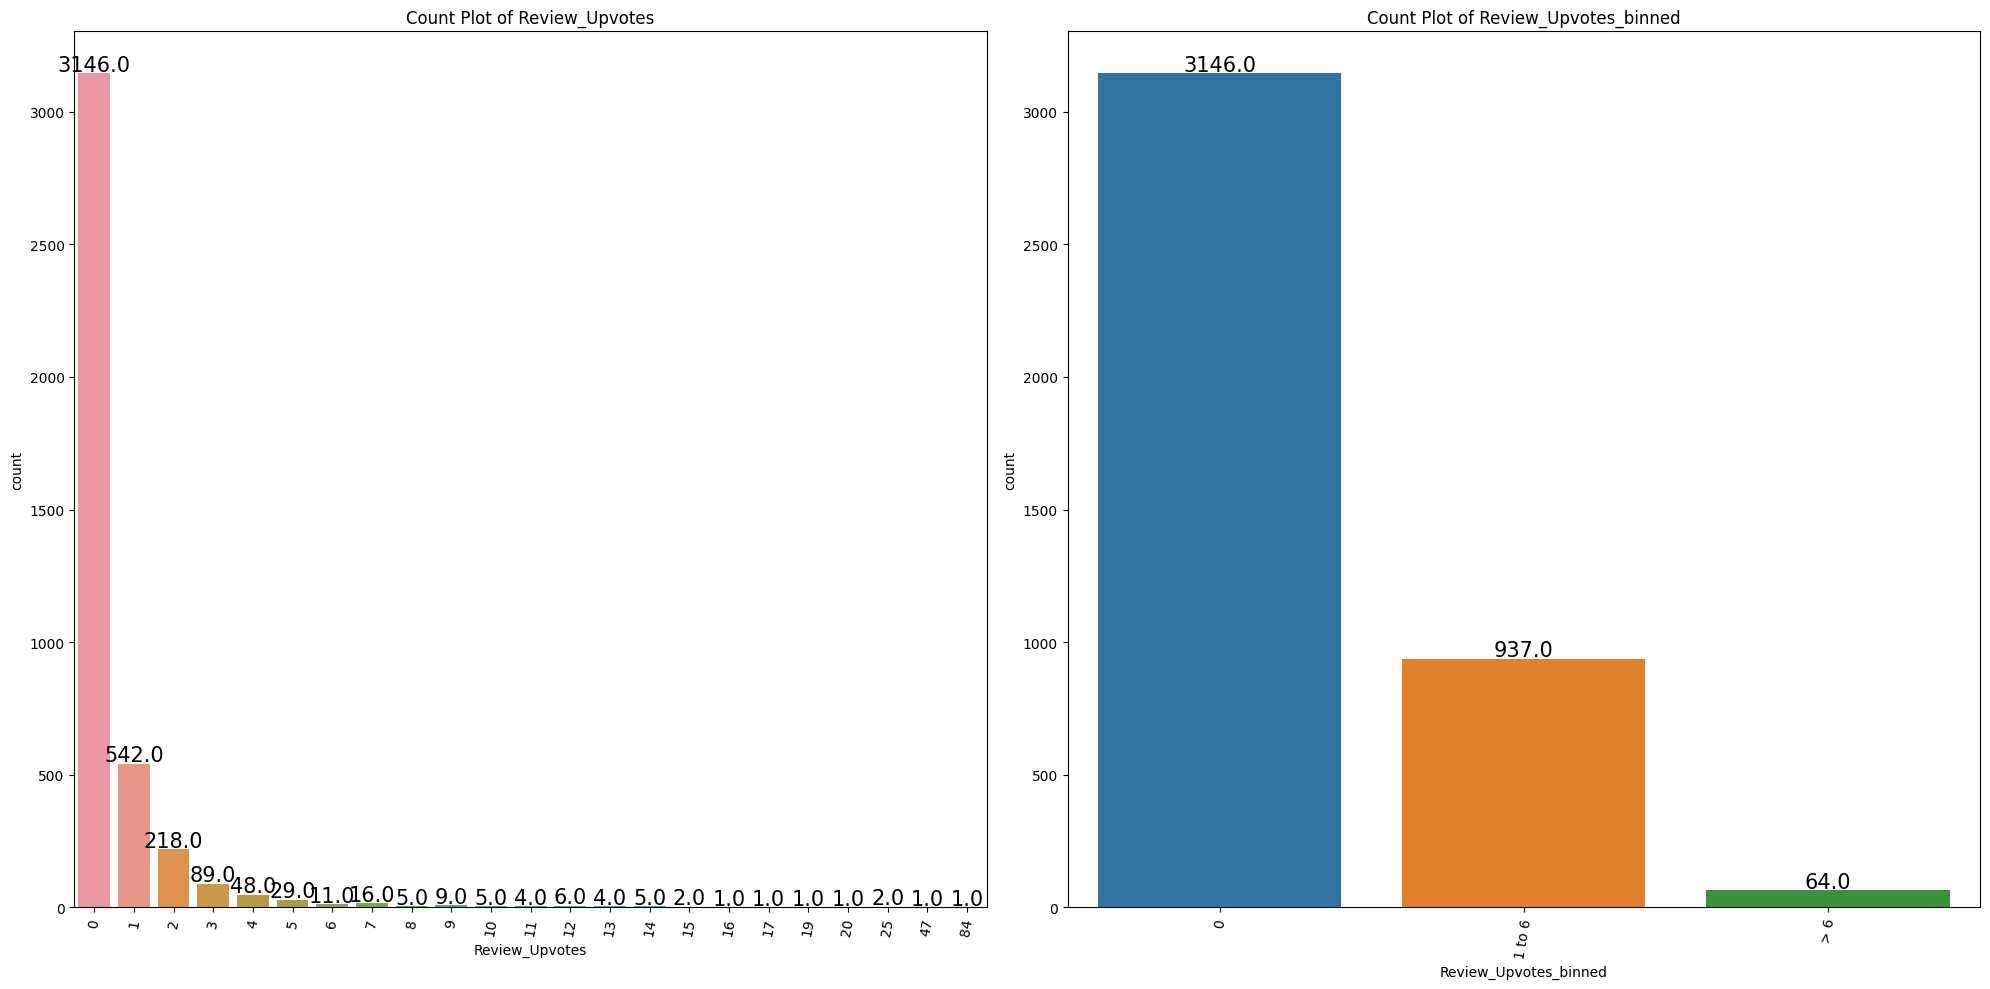

In [196]:
# Comparing plot count for Review_Upvotes before and after binning
feats = [ "Review_Upvotes", "Review_Upvotes_binned"]
plot_counts(
    data=new_rev, features=feats, n_rows=1, n_cols=2, figsize=(20, 10)
)

##### **Review_Downvotes**

In [197]:
# Group the Review_downvotes into three
feature_bin (data = new_rev, feature = "Review_Downvotes", choicelist = ["0", "1 to 6", "> 6"], val_1 = 0, a = 1, b = 7, c = 6)

Review_Downvotes Review_Downvotes_binned
2802                 0                       0
868                  0                       0
3824                 1                  1 to 6
1552                 0                       0
185                  2                  1 to 6
114                  1                  1 to 6
4027                 0                       0
2519                 0                       0
624                  0                       0
3631                 0                       0

In [198]:
# Verify
new_rev["Review_Downvotes_binned"].value_counts()

0         3782
1 to 6     347
> 6         18
Name: Review_Downvotes_binned, dtype: int64

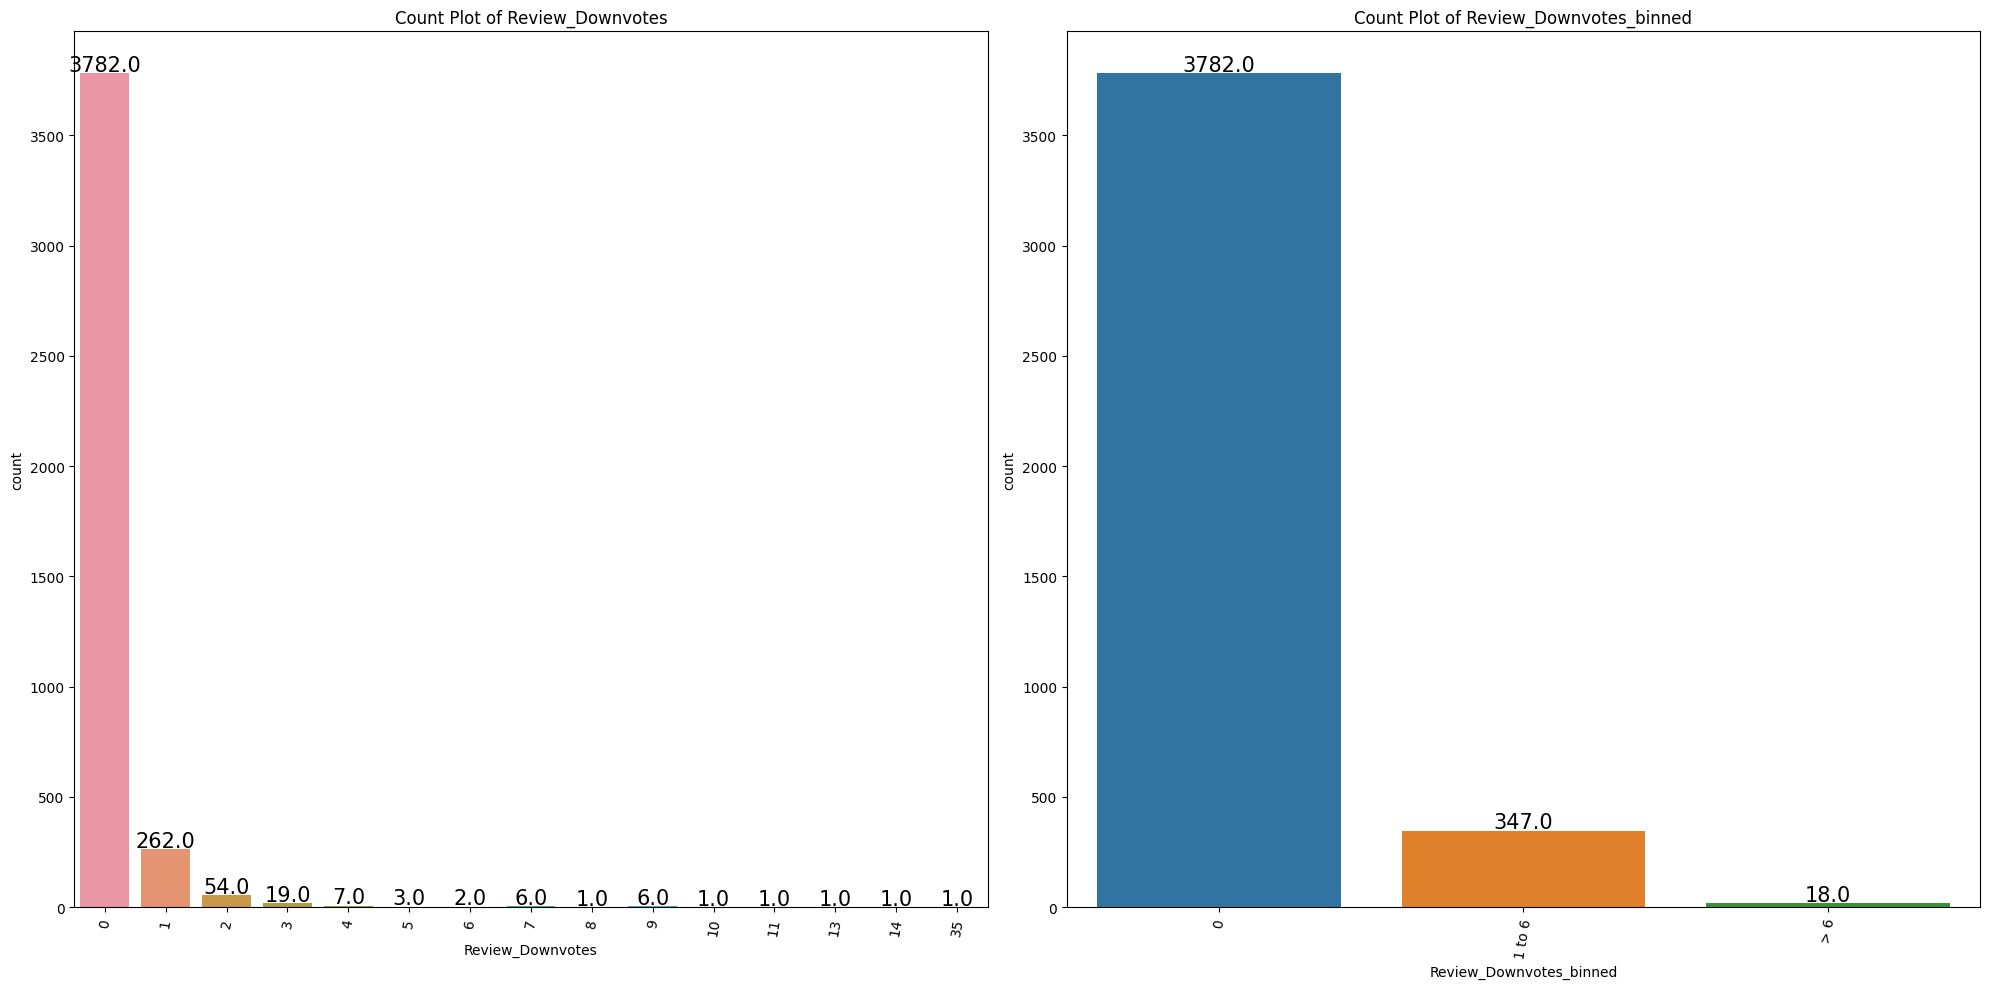

In [199]:
# Compare plot count for Review_Downvotes before and after binning
feats = [ "Review_Downvotes", "Review_Downvotes_binned"]
plot_counts(
    data=new_rev, features=feats, n_rows=1, n_cols=2, figsize=(20, 10)
)

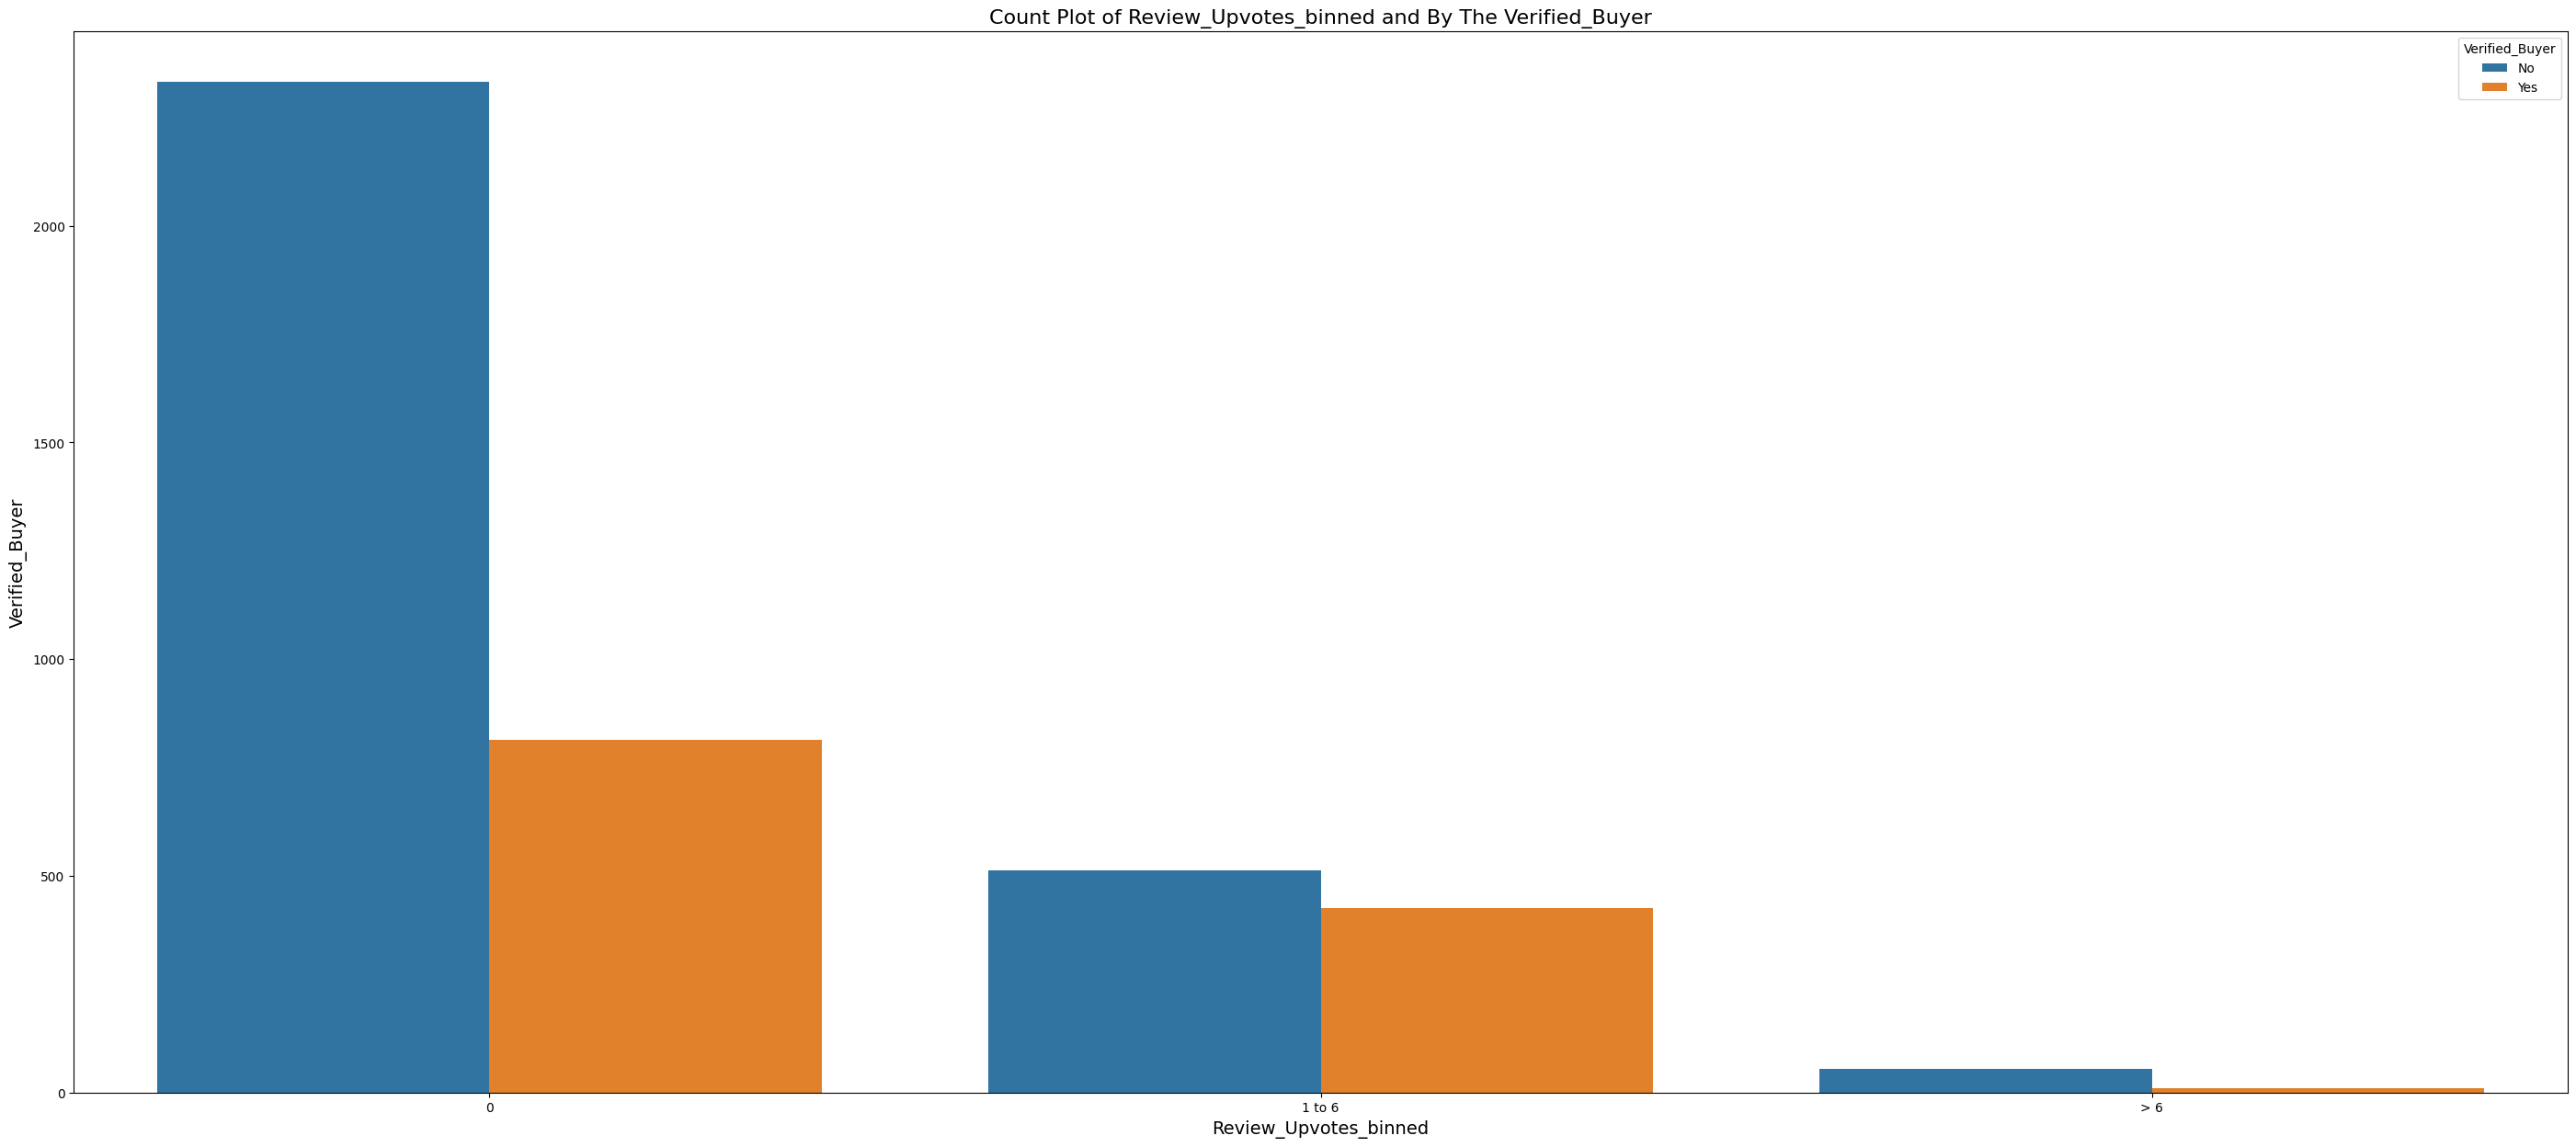

In [200]:
# Review_upvotes_binned and verified_buyer
plt.figure(figsize=[35, 15])  # Figure size

x, y = "Review_Upvotes_binned", "Verified_Buyer"
sns.countplot(x=x, hue=y, data=new_rev)
plt.xlabel(f"{x}", size=14)
plt.ylabel(f"{y}", size=14)
plt.title(f"Count Plot of {x} and By The {y}", size=16)

# plt.tight_layout()
plt.show()

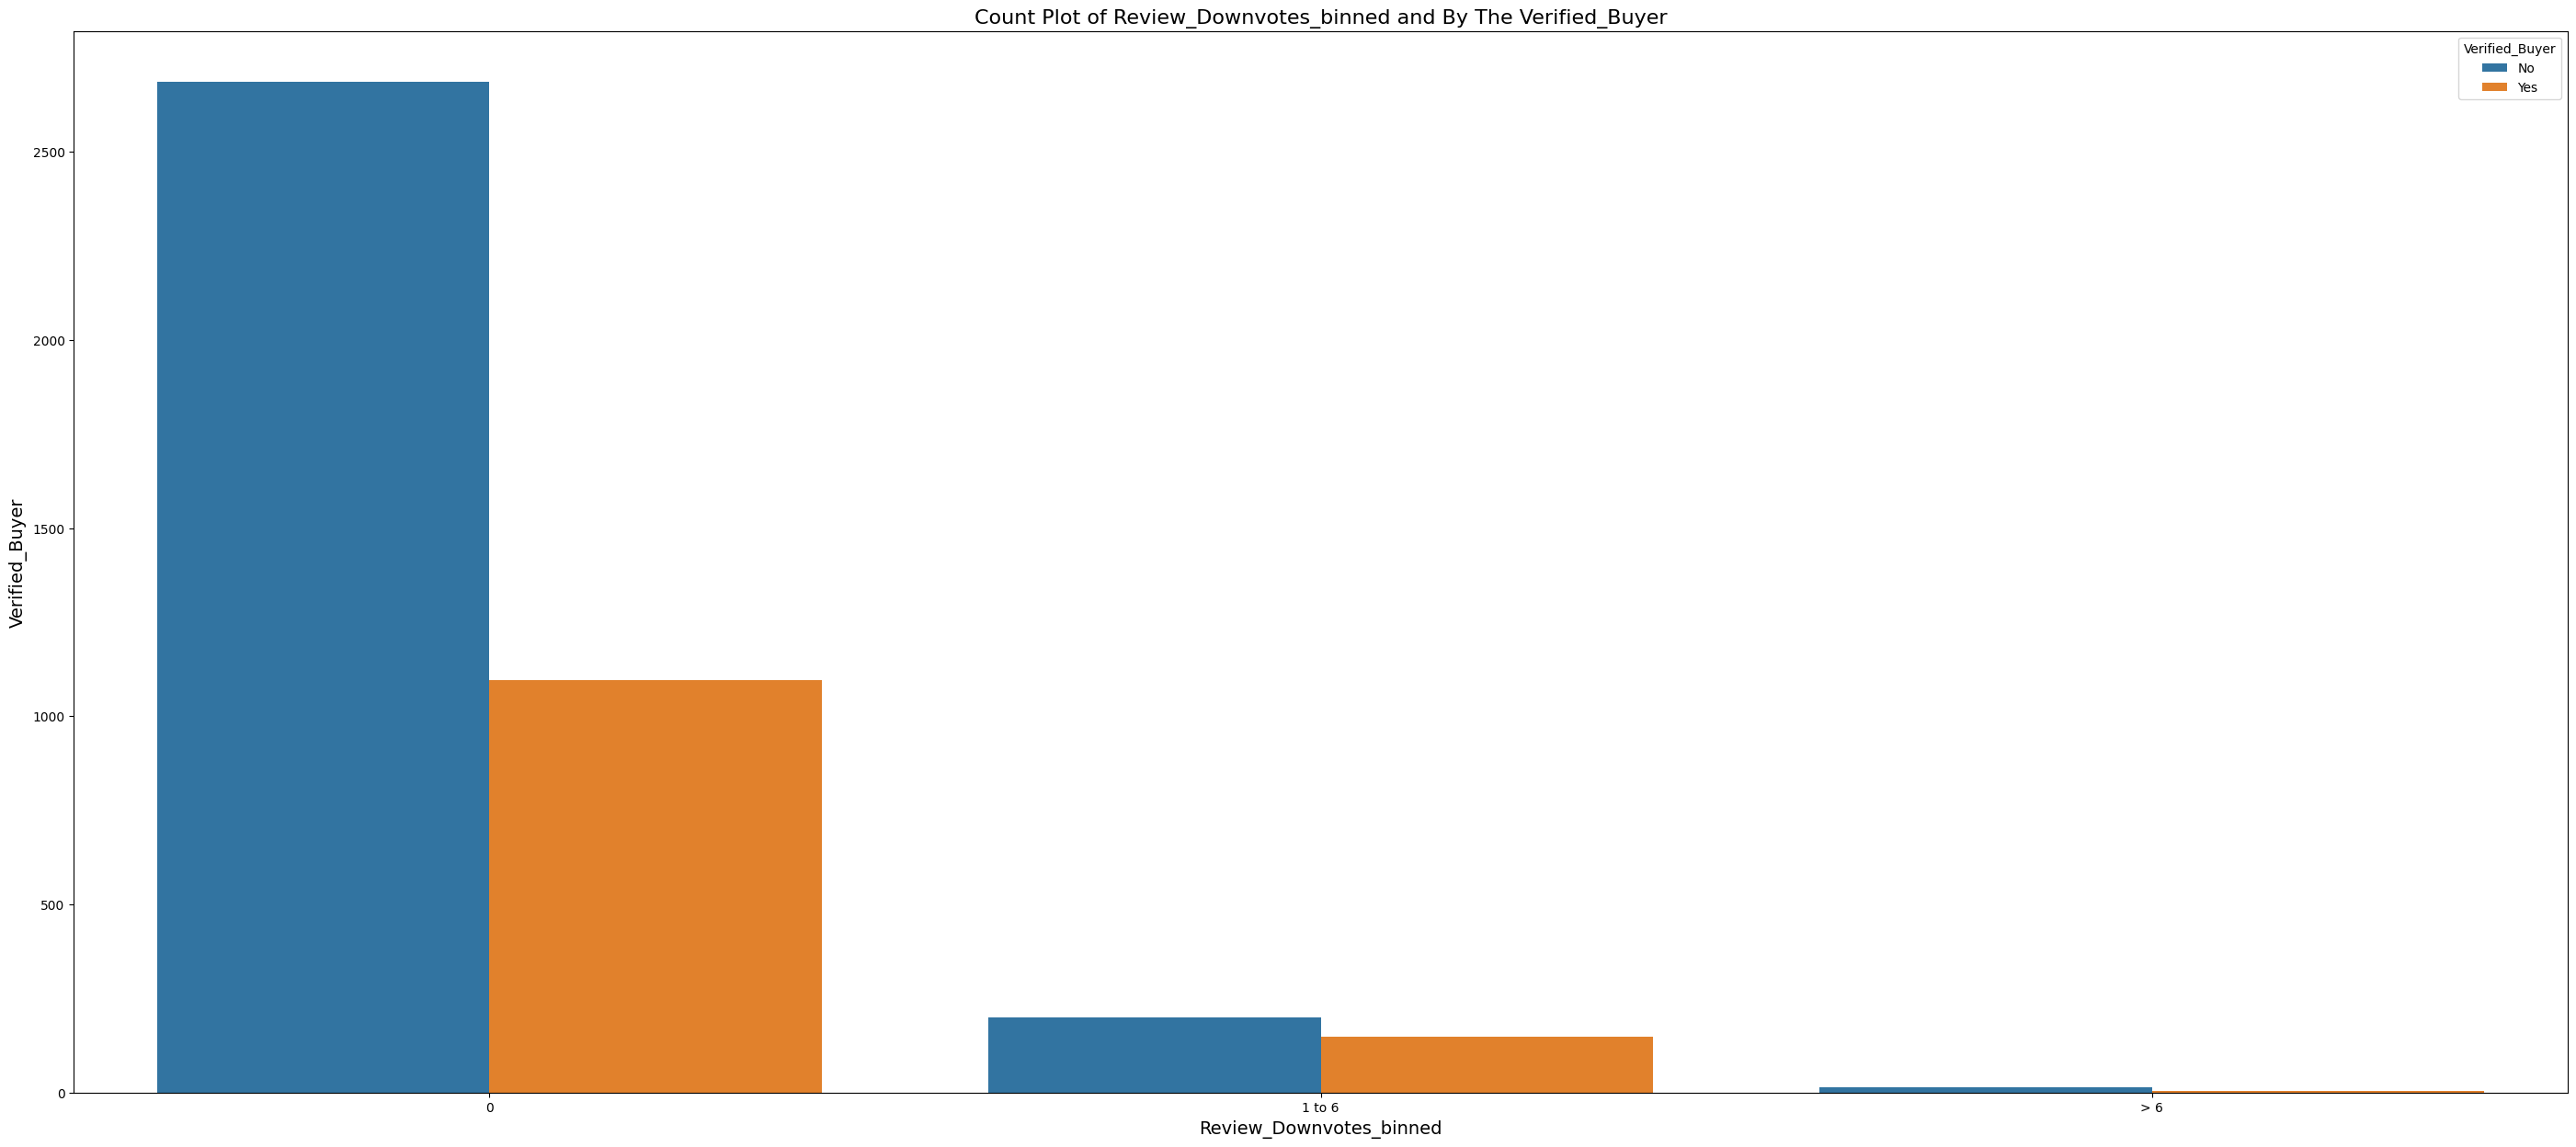

In [201]:
# Review_downvotes_binned and verified_buyer
plt.figure(figsize=[35, 15])  # Figure size

x, y = "Review_Downvotes_binned", "Verified_Buyer"
sns.countplot(x=x, hue=y, data=new_rev)
plt.xlabel(f"{x}", size=14)
plt.ylabel(f"{y}", size=14)
plt.title(f"Count Plot of {x} and By The {y}", size=16)

# plt.tight_layout()
plt.show()

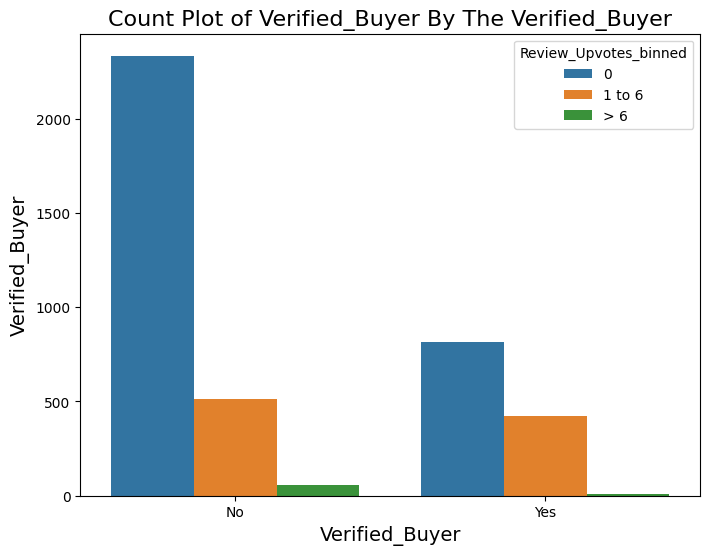

In [202]:
# Count and compare review_upvotes and verified_buyers
#figure size
plt.figure(figsize=[8, 6])  

x = "Verified_Buyer"
sns.countplot(x=x, data=new_rev, hue = "Review_Upvotes_binned")
plt.xlabel(f"{x}", size=14)
plt.ylabel(f"{y}", size=14)
plt.title(f"Count Plot of {x} By The {y}", size=16)


plt.show()

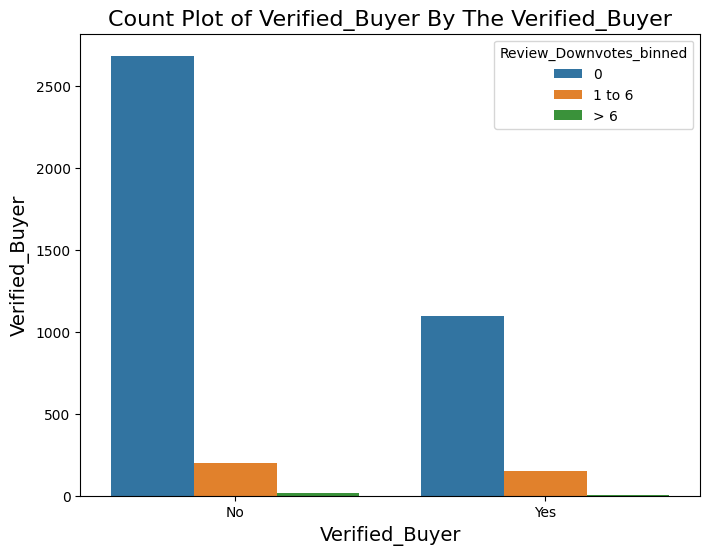

In [203]:
# Count and compare review_downvotes and verified_buyers
#figure size
plt.figure(figsize=[8, 6])  

x = "Verified_Buyer"
sns.countplot(x=x, data=new_rev, hue = "Review_Downvotes_binned")
plt.xlabel(f"{x}", size=14)
plt.ylabel(f"{y}", size=14)
plt.title(f"Count Plot of {x} By The {y}", size=16)


plt.show()

From the plots between the votes and the verified_buyer, it shows that majority reviews were neither upvoted or downvoted for. It did not matter whether the buyer was verified or not.

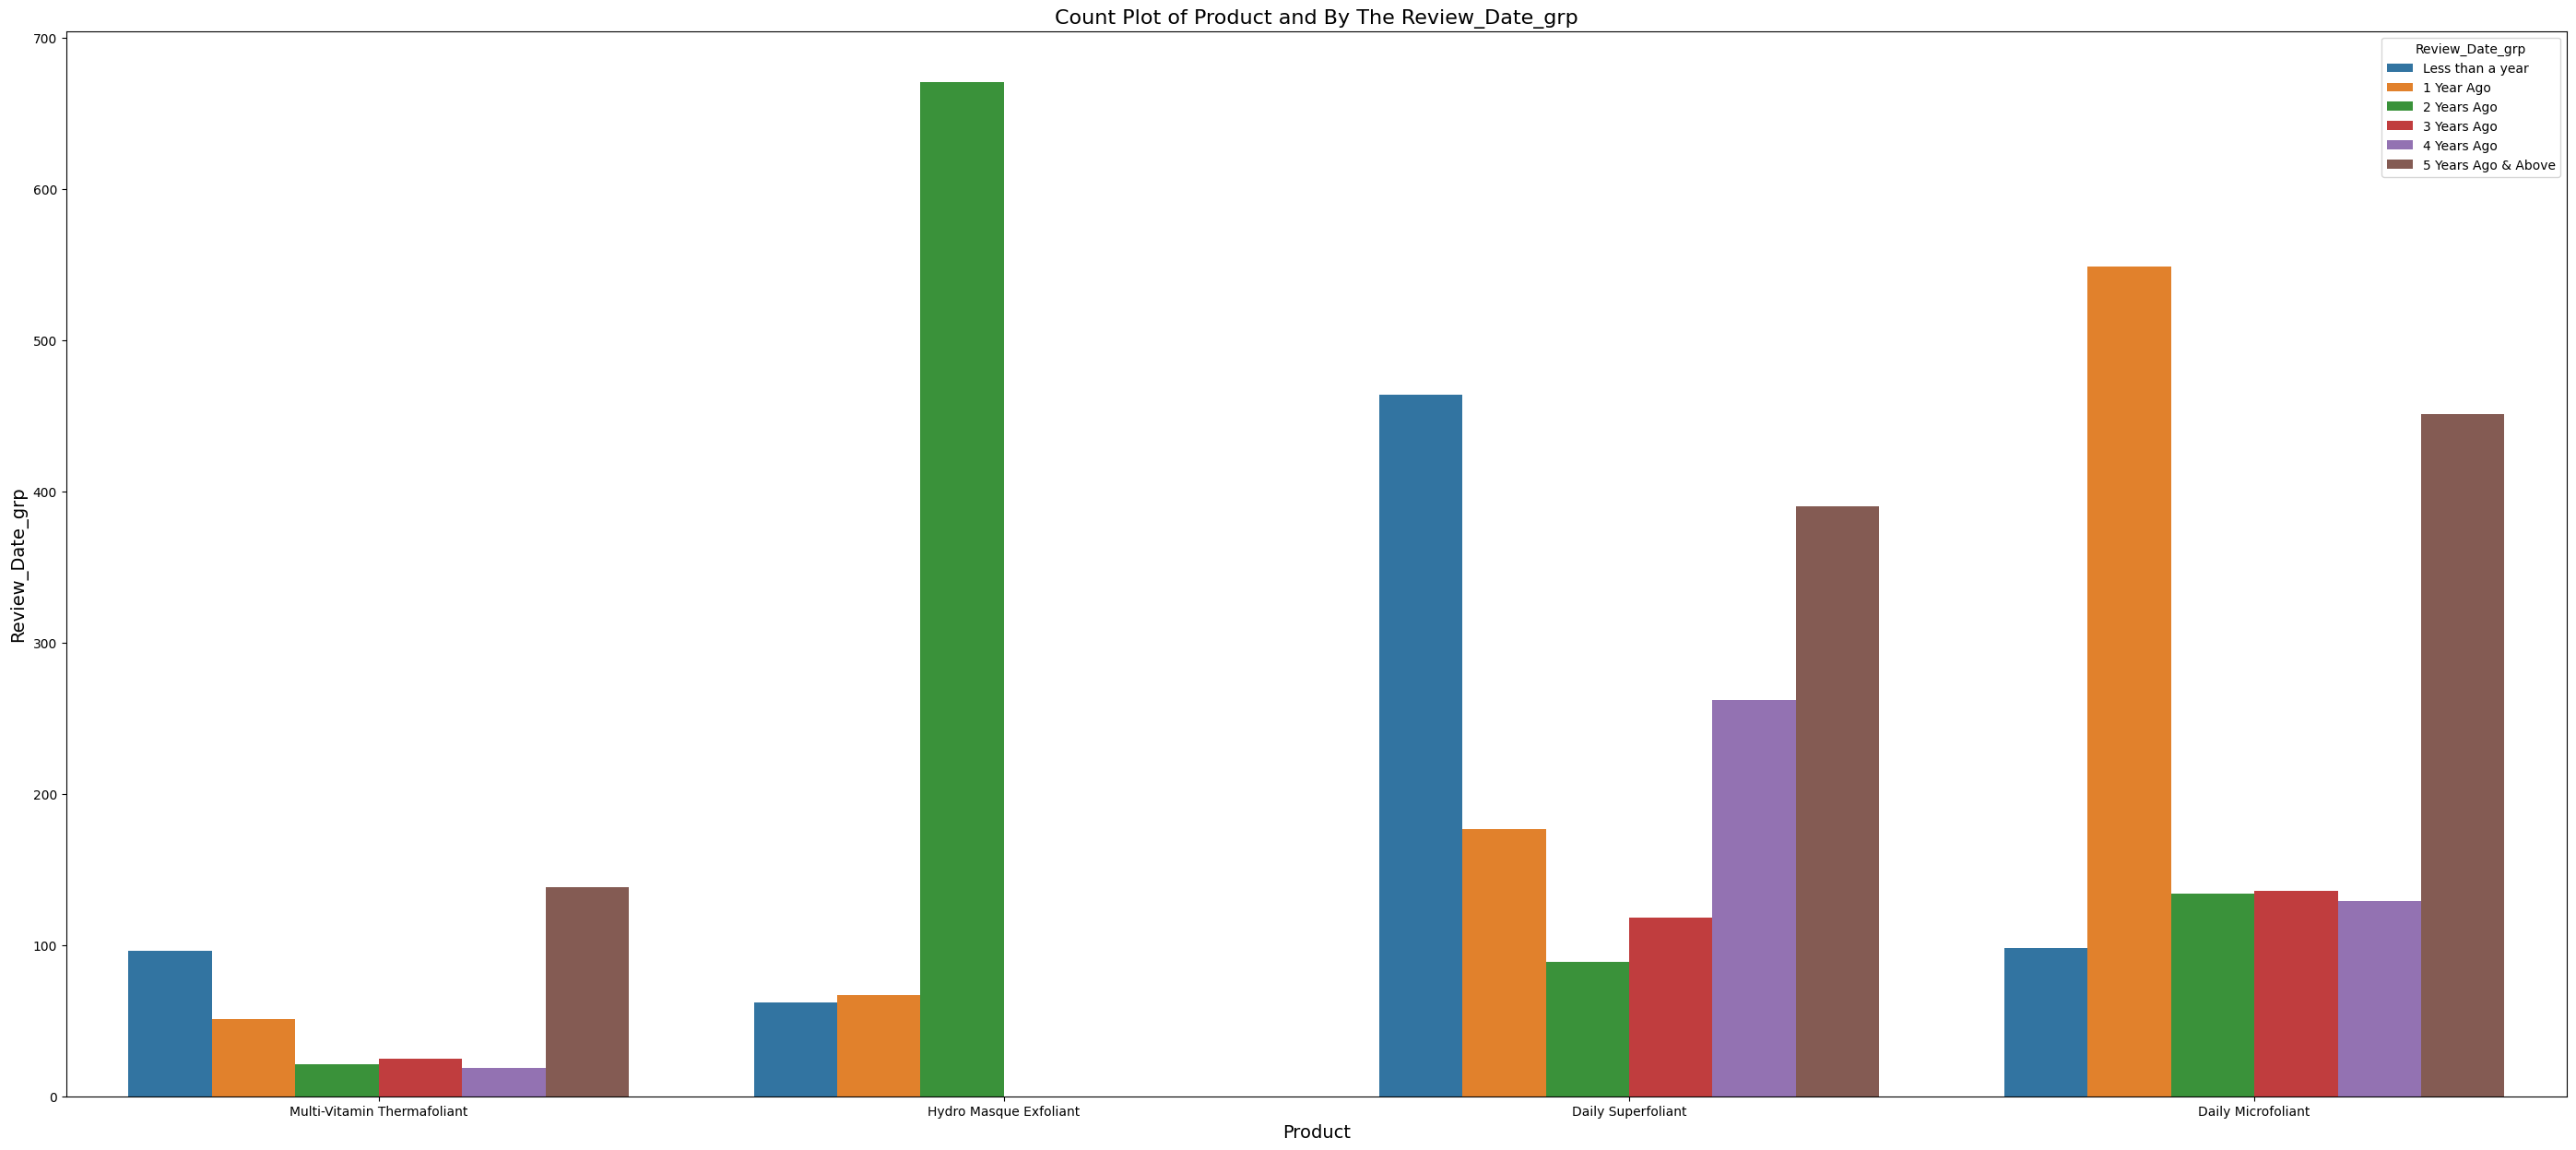

In [204]:
# Plot of products and review_date

plt.figure(figsize=[35, 15])  # Figure size

x, y = "Product", "Review_Date_grp"
sns.countplot(x=x, hue=y, data=new_rev)
plt.xlabel(f"{x}", size=14)
plt.ylabel(f"{y}", size=14)
plt.title(f"Count Plot of {x} and By The {y}", size=16)

# plt.tight_layout()
plt.show()

##### **Exploring Review_Text**

In [205]:
# Combine the whole text to a single file.
"".join(new_rev["Review_Text"].tolist())

'Love using this on my face while in the shower. Heats up and gives a light scrub nicelyEven better than the daily microfoliant. I\'m obsessed. My skin is SO MUCH smootherEnjoy this product so much ! I look forward to using it - really feels great.I\'ve never tried anything like this before and I love it. When you apply it to your face you get a little shot of warm that feels so good. The scrub seems very gritty but the only side effects I\'ve encountered have been positive ones.This exfoliates very nicely and gives a very smooth skin after with no irritation and no reaction to the skin . I highly recommended it, i will buy it again.Love that you can use it wet and dry, you can control how abrasive it is. Leaves your face soft and drenched in vitamins.Absolutely loveI truly like the multivitamin thermafoliant product, which I have been using for the last 7 years. I\'m very happy to purchase directly since it\'s no longer available from the Ulta store.Definitely love it! My skin face fe

In [206]:
# Turn the contraction to the expansion version
# This cleans the text and removes charcters like \'m, \'s as seen in the text above.
# contractions : expansions
contractions = {
    "ain't" : "am not",
    "aren't" : "are not",
    "can't" : "cannot",
    "can't've" : "cannot have",
    "'cause" : "because",
    "could've" : "could have",
    "couldn't" : "could not",
    "Couldn't" : "Could not",
    "couldn't've" : "could not have",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hadn't've" : "had not have",
    "hasn't" : "has not",
    "haven't" : "have not",
    "Haven't" : "Have not",
    "he'd" : "he would",
    "he'd've" : "he would have",
    "he'll" : "he will",
    "he's" : "he is",
    "how'd" : "how did",
    "how'd'y" : "how do you",
    "how'll" : "how will",
    "how's" : "how does",
    "i'd" : "i would",
    "I'd" : "I would",
    "I'd've" : "I would have",
    "I'll" : "I will",
    "i'd've" : "i would have",
    "i'll" : "i will",
    "i'll've" : " i will have",
    "I'll've" : " I will have",
    "i'm" : "i am",
    "I'm" : "I am",
    "i've" : "i have",
    "I've" : "I have",
    "isn't" : "is not",
    "it'd" : "it would",
    "it'd've" : "it would have",
    "it'll" : "it will",
    "it'll've" : "it will have",
    "it's" : "it is",
    "It's" : "It is",
    "let's" : "let us",
    "ma'am" : "madam",
    "mayn't" : "may not",
    "might've" : "might have",
    "mightn't" : "might not",
    "mightn't've" : "might not have",
    "must've" : "must have",
    "mustn't" : "must not",
    "mustn't've" : "must not have",
    "needn't" : "need not",
    "needn't've" : "need not have",
    "o'clock" : "of the clock",
    "oughtn't" : "ought not",
    "shan't" : "shall not",
    "sha'n't" : "shall not",
    "shan't've" : "shall not have",
    "she'd" : "she would",
    "she'd've" : "she would have",
    "she'll" : "she will",
    "she'll've" : "she will have",
    "she's" : "she is",
    "should've" : "should have",
    "shouldn't" : "should not",
    "shouldn't've" : "should not have",
    "so've" : "so have",
    "so's" : "so is",
    "that'd" : "that would",
    "that'd've" : "that would have",
    "that's" : "that is",
    "there'd" : "there would",
    "there'd've" : "there would have",
    "there's" : "there is",
    "they'd" : "they would",
    "they'd've" : "they would have",
    "they'll" : "they will",
    "they'll've" : "they will have",
    "they're" : "they are",
    "they've": "they have",
    "to've" : "to have",
    "wasn't" :"was not",
    "we've" : "we have",
    "you're" : "you are",
    
}

In [207]:
new_rev["Review_Text"] = new_rev["Review_Text"].apply(lambda val : cont_to_expd(val))

In [208]:
# Verify
new_rev["Review_Text"].head(10)

0                                                                                                                                                           Love using this on my face while in the shower. Heats up and gives a light scrub nicely
1                                                                                                                                                               Even better than the daily microfoliant. I am obsessed. My skin is SO MUCH smoother
2                                                                                                                                                                     Enjoy this product so much ! I look forward to using it - really feels great.
3    I have never tried anything like this before and I love it. When you apply it to your face you get a little shot of warm that feels so good. The scrub seems very gritty but the only side effects I have encountered have been positive ones.
4                       

In [209]:
# Check for polarity of the review_text
new_rev["Polarity"] = new_rev["Review_Text"].apply(lambda val : TextBlob(val).sentiment.polarity)

In [210]:
# The word count of each character in a review text
new_rev["Word_Count"] = new_rev["Review_Text"].apply(lambda val : len(val.split()))

In [211]:
# The average word length of review text
new_rev["Avg_Word_Len"] = new_rev["Review_Text"].apply(lambda x : avg_word_length(x))

In [212]:
# Show the added columns
new_rev.head()

Review_Text  \
0                                                                                                                                                         Love using this on my face while in the shower. Heats up and gives a light scrub nicely   
1                                                                                                                                                             Even better than the daily microfoliant. I am obsessed. My skin is SO MUCH smoother   
2                                                                                                                                                                   Enjoy this product so much ! I look forward to using it - really feels great.   
3  I have never tried anything like this before and I love it. When you apply it to your face you get a little shot of warm that feels so good. The scrub seems very gritty but the only side effects I have encountered have been positive ones.   
4                                                                                   This exfoliates very nicely and gives a very smooth skin after with no irritation and no reaction to the skin . I highly recommended it, i will buy it again.   

  Verified_Buyer   Review_Date Review_Location  Review_Upvotes  \
0             No   15 days ago     Undisclosed               0   
1             No   27 days ago     Undisclosed               0   
2             No  2 months ago     Undisclosed               0   
3             No  2 months ago     Undisclosed               0   
4             No  2 months ago     Undisclosed               0   

   Review_Downvotes                      Product   Review_Date_grp  \
0                 0  Multi-Vitamin Thermafoliant  Less than a year   
1                 0  Multi-Vitamin Thermafoliant  Less than a year   
2                 0  Multi-Vitamin Thermafoliant  Less than a year   
3                 0  Multi-Vitamin Thermafoliant  Less than a year   
4                 0  Multi-Vitamin Thermafoliant  Less than a year   

  Review_Upvotes_binned Review_Downvotes_binned  Polarity  Word_Count  \
0                     0                       0  0.500000          18   
1                     0                       0  0.050000          15   
2                     0                       0  0.412500          16   
3                     0                       0  0.262825          47   
4                     0                       0  0.486667          30   

   Avg_Word_Len  
0      3.888889  
1      4.600000  
2      3.875000  
3      4.085106  
4      4.266667

The above shows the Word_Count, Polarity and Average_word_length of the Review_Text. The first row shows there are 18 words in the review, and an average of 4 characters per word.

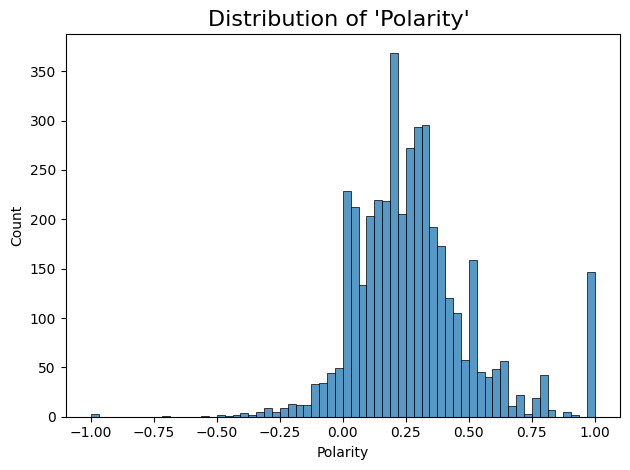

In [213]:
# Histogram of polarity
plot_histogram(data = new_rev, feature = "Polarity")

This shows there are more positive reviews than negative reviews.

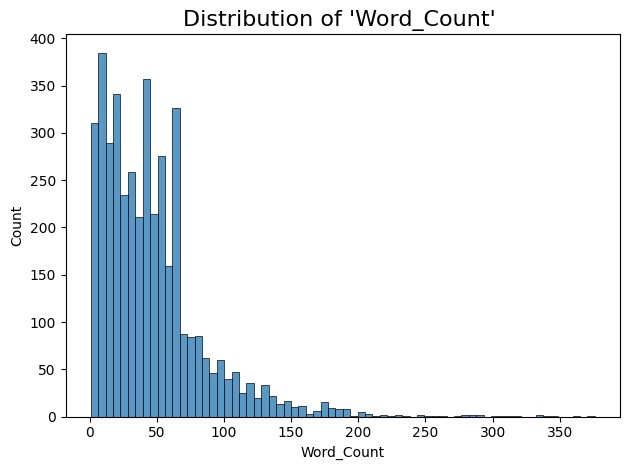

In [214]:
# Histogram of word_count
plot_histogram(data = new_rev, feature = "Word_Count")

Majority of the review text consists of 2 to about 55 words.

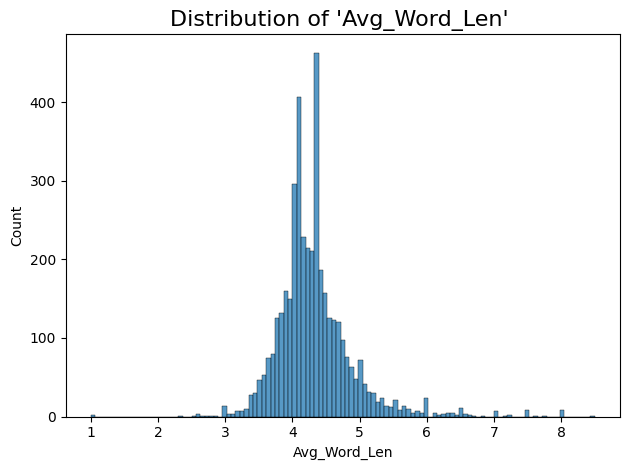

In [215]:
# Histogram of average word length
plot_histogram(data = new_rev, feature = "Avg_Word_Len")

Most of the words in the Review_Text are made up of 4 charcters on an average.

##### **Product and Polarity Relationship**

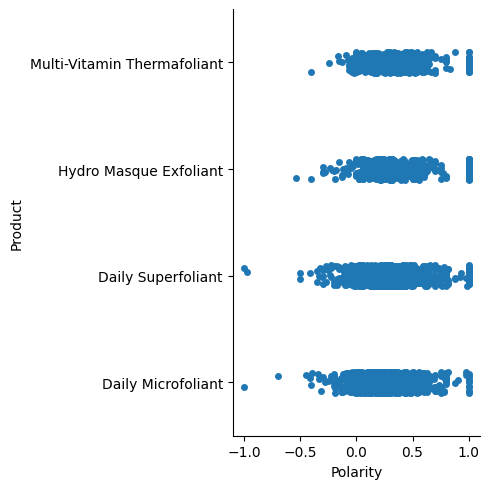

In [216]:
sns.catplot(x = "Polarity", y = "Product", data = new_rev)

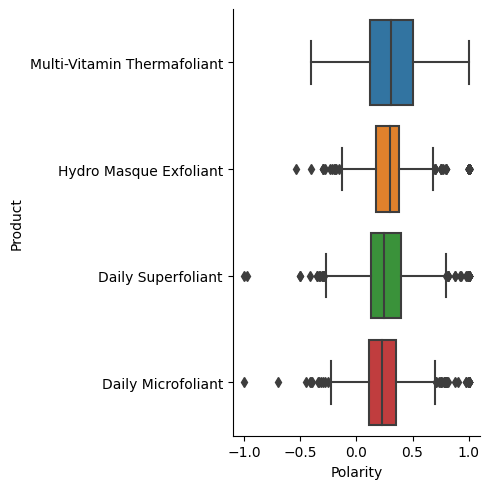

In [217]:
sns.catplot(x = "Polarity", y = "Product", data = new_rev, kind = "box")

##### **Polarity and Review_Date_grp**

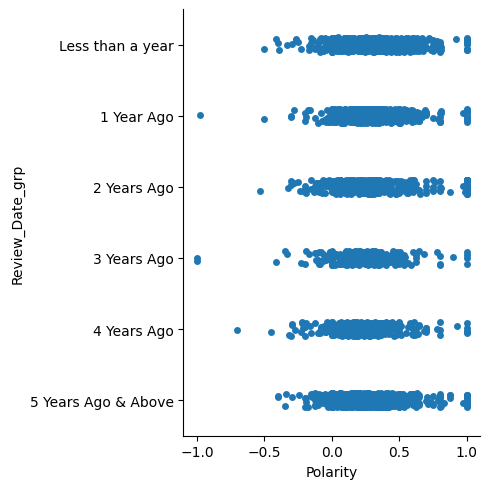

In [218]:
sns.catplot(x = "Polarity", y = "Review_Date_grp", data = new_rev)

From the plots above between the polarity and products, it confirms that Most reviews are in Daily superfoliant and Daily Microfolaint. It is seen that most reviews about the products are generally positive reviews. it also shows that the majority of the  negative reviews are likely to be found in the daily superfoliant and daily microfolint. It also shows that the more negative reviews are from 3 years ago.


## Comment:<br>The subsequent conclusions can be reached from the exploratory data analysis;


* The majority of the customers are Americans, which may indicate that the company making these products is based in the United States.


*   The product with the most reviews is the Daily Superfoliant.



*   Regardless of whether the buyer is verified, the majority of reviews received neither upvotes nor downvotes.


*   A large percentage of the reviewers are not verified buyers.


*   The Hydro Masque Exfoliant had the highest reviews two years ago, with no reviews from three years or older.

*   The Multi-Vitamin Thermafoliant received the fewest views.


*   The majority of consumers are pleased with the products.


*   The Majority of consumers have either sensitive or dry skin.

*  The product should be used on a daily basis for the best results.



*   The Daily Superfoliant and Daily Microfoliant received more negative reviews. This is most likely due to the greater quantity of reviews for these products.



*   More negative reviews are from three years ago. This is most likely because the Daily Superfoliant and Daily Microfoliant received more feedback three years ago when compared to earlier years.






###  Qs 2. Create a wordcloud showing the words/phrases commonly associated with each product.

In [219]:
# The products
new_rev["Product"].unique()

array(['Multi-Vitamin Thermafoliant', 'Hydro Masque Exfoliant',
       'Daily Superfoliant', 'Daily Microfoliant'], dtype=object)

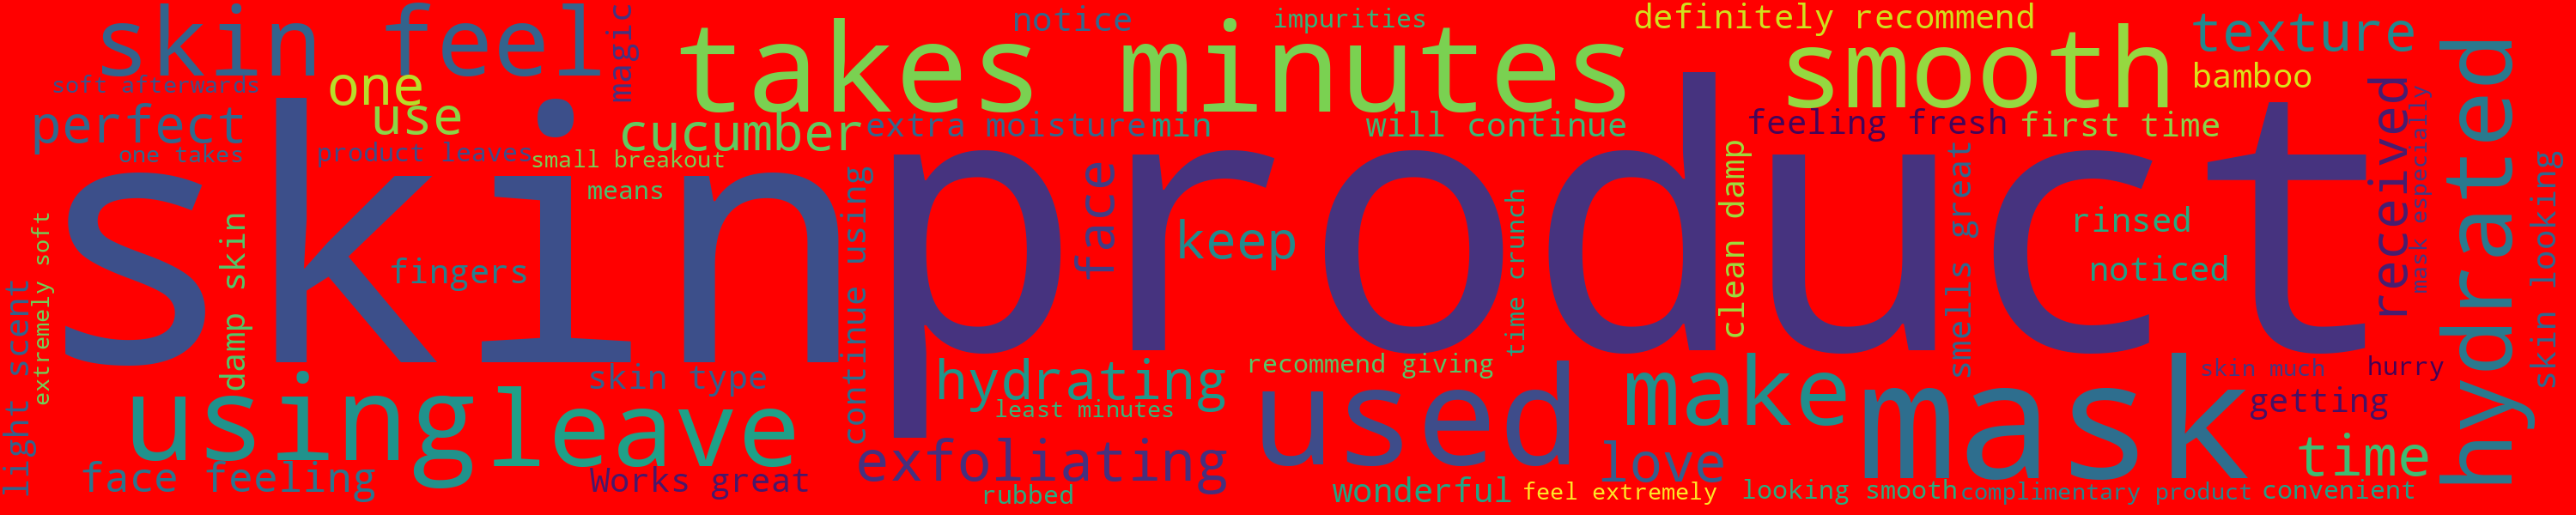

In [220]:
# Wordcloud for the Hydro Masque Exfoliant Product
my_wordcloud(data = new_rev, feature = "Product", variable = "Hydro Masque Exfoliant", Text_var = "Review_Text", color = "Red")

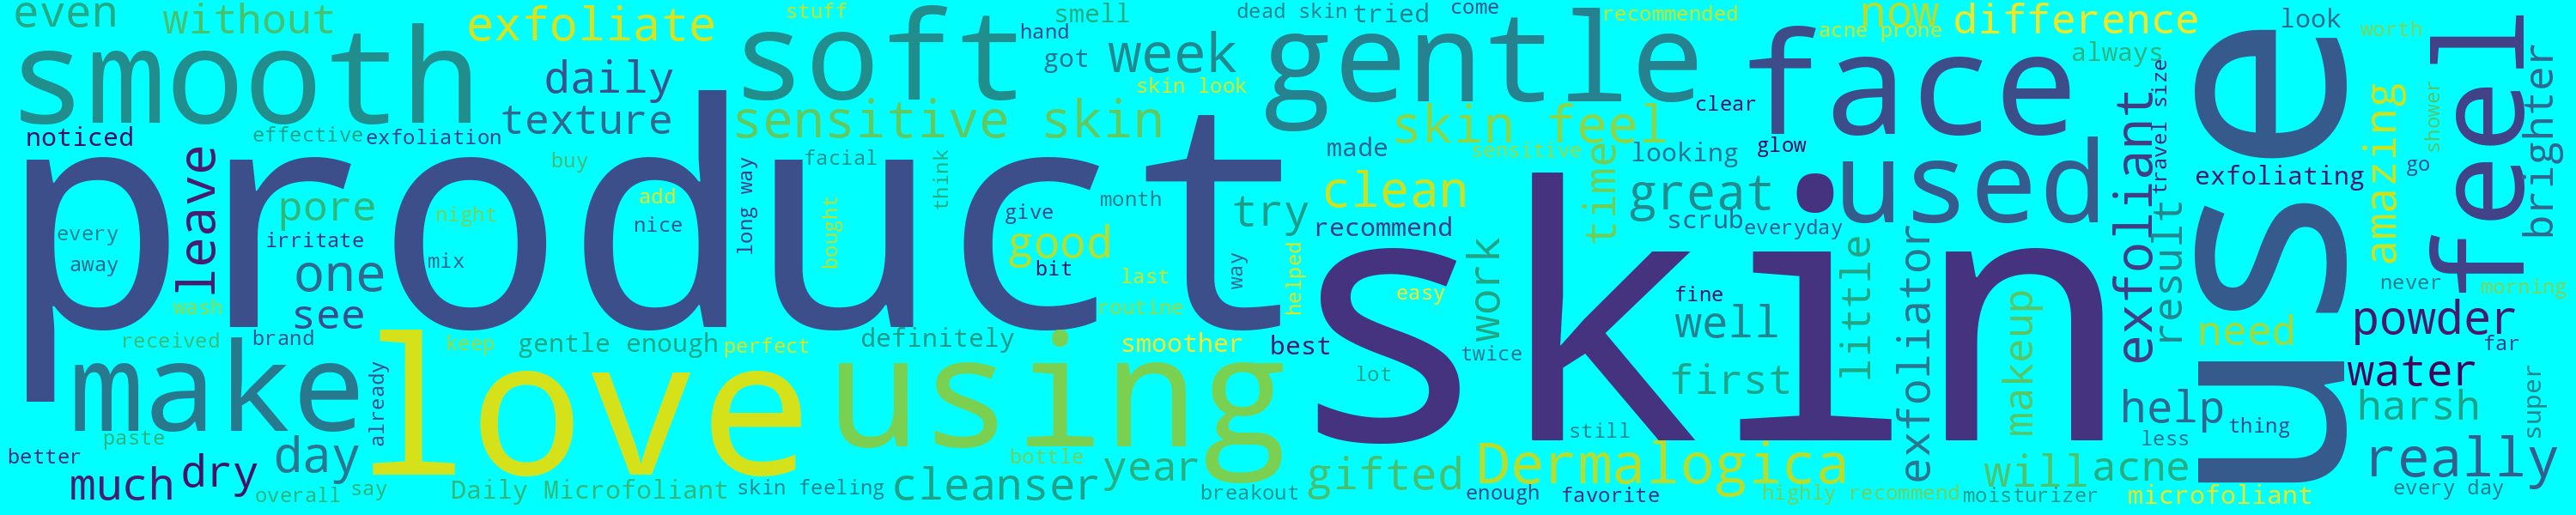

In [221]:
# Wordcloud for the Daily Microfoliant Product
my_wordcloud(data = new_rev, feature = "Product", variable = "Daily Microfoliant", Text_var = "Review_Text", color = "Cyan")

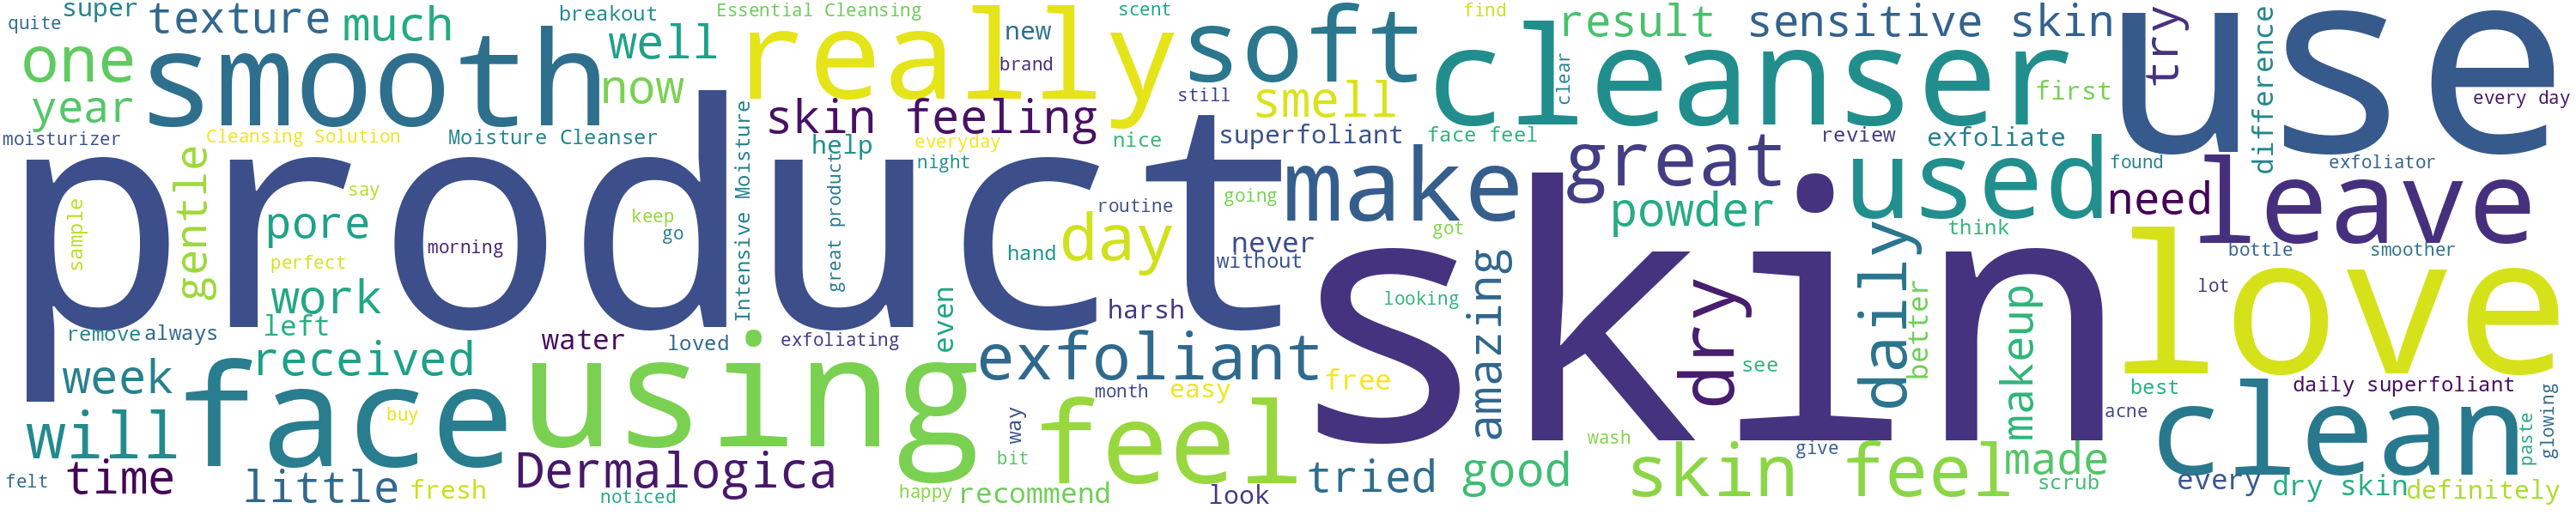

In [222]:
# Wordcloud for the Daily Superfoliant Product
my_wordcloud(data = new_rev, feature = "Product", variable = "Daily Superfoliant", Text_var = "Review_Text", color = "White")

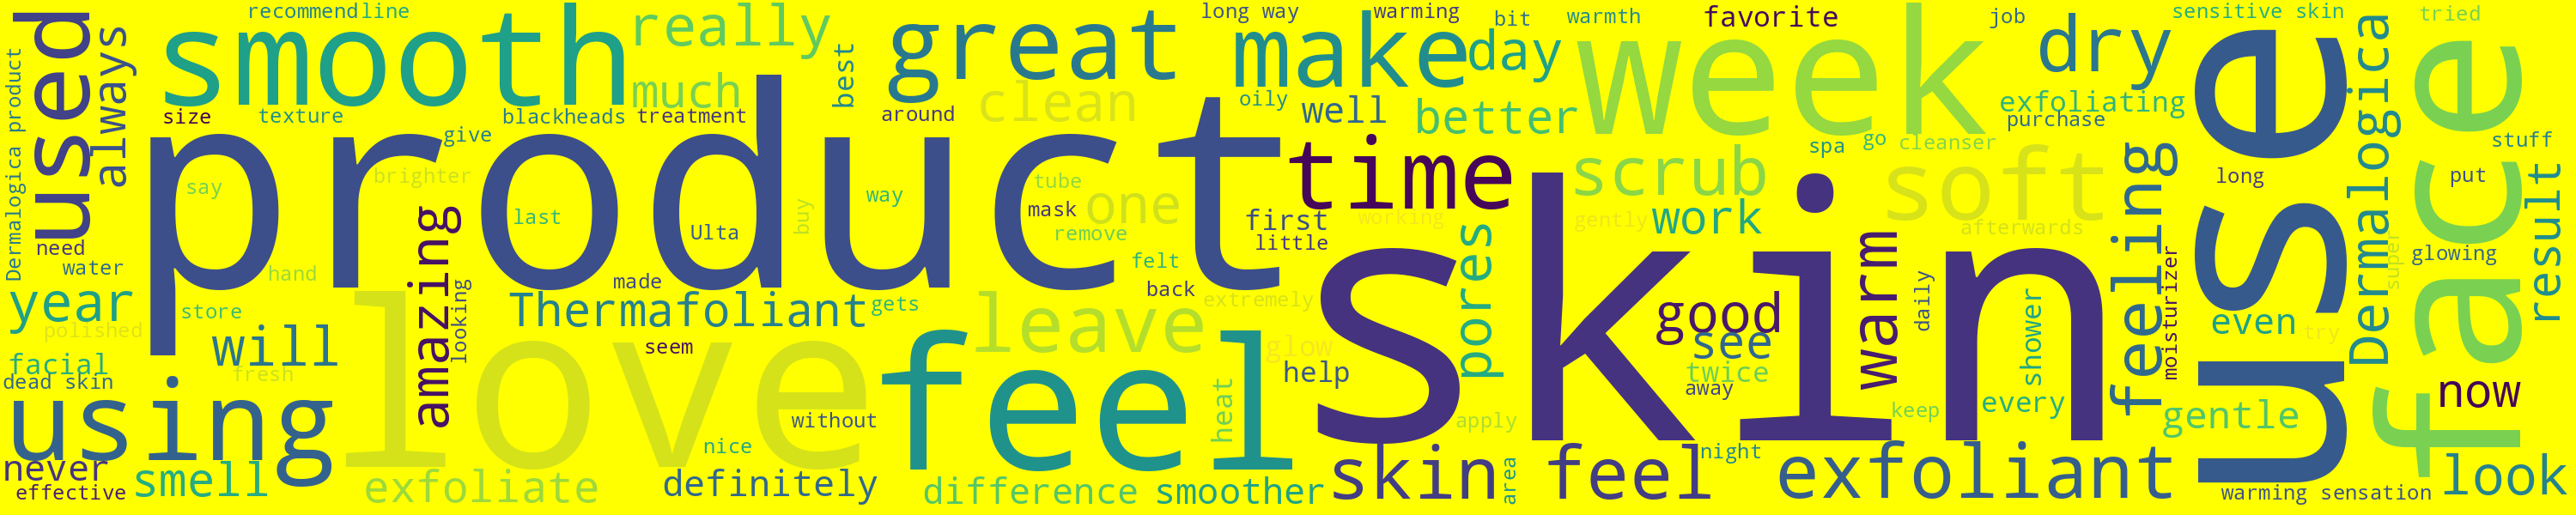

In [223]:
# Wordcloud for the Multi-Vitamin Thermafoliant Product
my_wordcloud(data = new_rev, feature = "Product", variable = "Multi-Vitamin Thermafoliant", Text_var = "Review_Text", color = "Yellow")

### Qs 3. Perform sentiment analysis. Build a ML model that can predict whether a review is positive or negative.

In [224]:
# Create a copy of the new_rev to be used for the sentiment analysis
sent_rev = new_rev.copy()
# Drop some columns
var_to_drop = ["Verified_Buyer", "Review_Date", "Review_Location", "Review_Upvotes", "Review_Downvotes", "Review_Upvotes_binned", "Review_Downvotes_binned"]
sent_rev.drop(columns = var_to_drop, inplace = True)

In [225]:
# View data
sent_rev.head()

Review_Text  \
0                                                                                                                                                         Love using this on my face while in the shower. Heats up and gives a light scrub nicely   
1                                                                                                                                                             Even better than the daily microfoliant. I am obsessed. My skin is SO MUCH smoother   
2                                                                                                                                                                   Enjoy this product so much ! I look forward to using it - really feels great.   
3  I have never tried anything like this before and I love it. When you apply it to your face you get a little shot of warm that feels so good. The scrub seems very gritty but the only side effects I have encountered have been positive ones.   
4                                                                                   This exfoliates very nicely and gives a very smooth skin after with no irritation and no reaction to the skin . I highly recommended it, i will buy it again.   

                       Product   Review_Date_grp  Polarity  Word_Count  \
0  Multi-Vitamin Thermafoliant  Less than a year  0.500000          18   
1  Multi-Vitamin Thermafoliant  Less than a year  0.050000          15   
2  Multi-Vitamin Thermafoliant  Less than a year  0.412500          16   
3  Multi-Vitamin Thermafoliant  Less than a year  0.262825          47   
4  Multi-Vitamin Thermafoliant  Less than a year  0.486667          30   

   Avg_Word_Len  
0      3.888889  
1      4.600000  
2      3.875000  
3      4.085106  
4      4.266667

In [226]:
# Bin the polarity such that review with negative polarity take 1 and reviews with positive polarity take 0
sent_feature_bin (data = sent_rev, feature = "Polarity", choicelist = ["0", "1"], a = 0, b = 1, c = 0)

Polarity Polarity_binned
2802  0.156944               0
868   0.060000               0
3824 -0.038244               1
1552  0.000000               0
185   0.255000               0
114   0.228571               0
4027  0.400000               0
2519  0.219670               0
624   0.129167               0
3631  0.200000               0

In [227]:
# Value count of binned polarity
sent_rev["Polarity_binned"].value_counts(normalize = True).mul(100)


0    94.18857
1     5.81143
Name: Polarity_binned, dtype: float64

In [228]:
# Check stop words in each of the review text
sent_rev["Stopword_count"] = new_rev["Review_Text"].apply(lambda x: len([char for char in x.split() if char in STOP_WORDS]))


In [229]:
sent_rev.head()

Review_Text  \
0                                                                                                                                                         Love using this on my face while in the shower. Heats up and gives a light scrub nicely   
1                                                                                                                                                             Even better than the daily microfoliant. I am obsessed. My skin is SO MUCH smoother   
2                                                                                                                                                                   Enjoy this product so much ! I look forward to using it - really feels great.   
3  I have never tried anything like this before and I love it. When you apply it to your face you get a little shot of warm that feels so good. The scrub seems very gritty but the only side effects I have encountered have been positive ones.   
4                                                                                   This exfoliates very nicely and gives a very smooth skin after with no irritation and no reaction to the skin . I highly recommended it, i will buy it again.   

                       Product   Review_Date_grp  Polarity  Word_Count  \
0  Multi-Vitamin Thermafoliant  Less than a year  0.500000          18   
1  Multi-Vitamin Thermafoliant  Less than a year  0.050000          15   
2  Multi-Vitamin Thermafoliant  Less than a year  0.412500          16   
3  Multi-Vitamin Thermafoliant  Less than a year  0.262825          47   
4  Multi-Vitamin Thermafoliant  Less than a year  0.486667          30   

   Avg_Word_Len Polarity_binned  Stopword_count  
0      3.888889               0              10  
1      4.600000               0               4  
2      3.875000               0               7  
3      4.085106               0              25  
4      4.266667               0              14

#### **Top 20 words and group of words that occured most frequenly excluding the stopwords.**

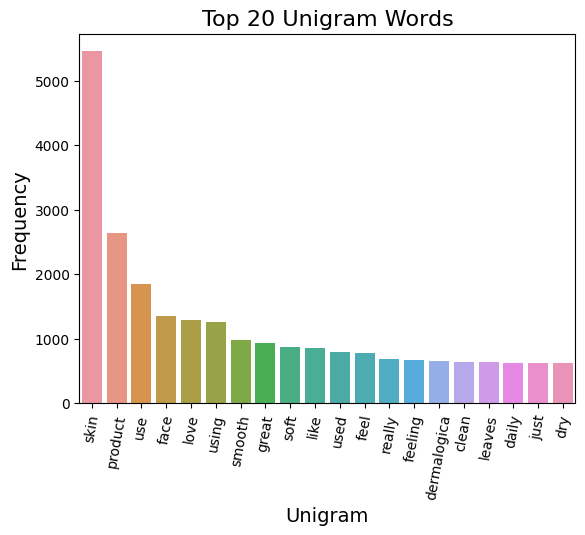

In [230]:
# Unigram words
word_gram(data = new_rev, feature = "Review_Text", a = 1, b = 1, n = 20, figsize = (20, 20), gram_type = "Unigram", Frequency = "Frequency")

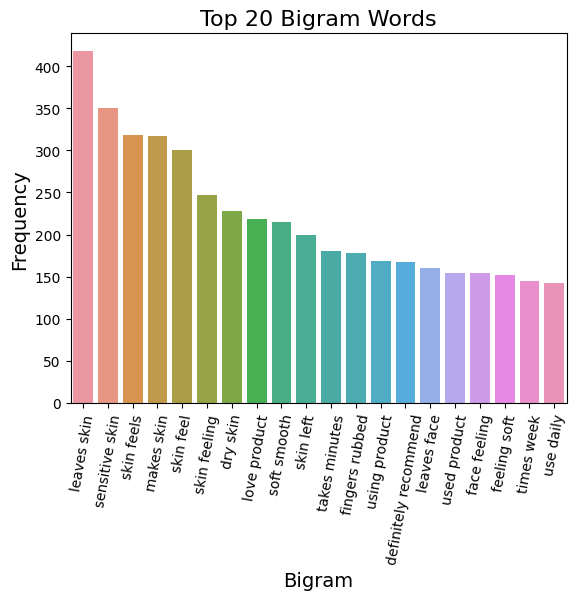

In [231]:
# Bigram Words
word_gram(data = new_rev, feature = "Review_Text", a = 2, b = 2, n = 20, figsize = (20, 20), gram_type = "Bigram", Frequency = "Frequency")

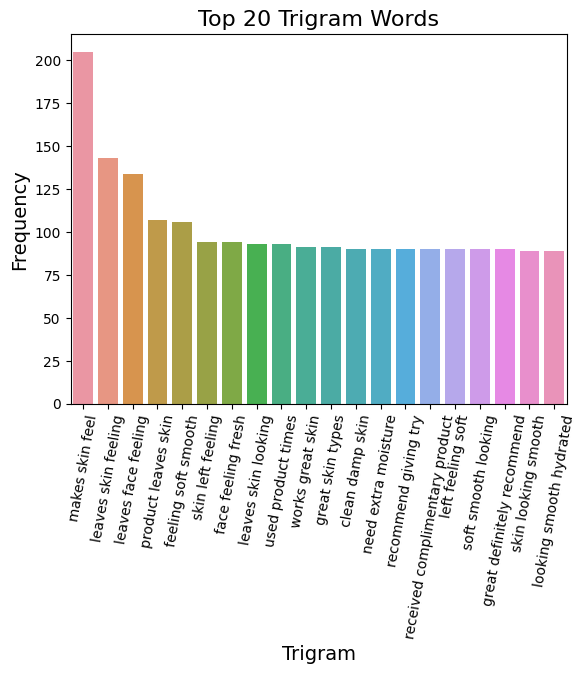

In [232]:
# Trigram words
word_gram(data = new_rev, feature = "Review_Text", a = 3, b = 3, n = 20, figsize = (20, 20), gram_type = "Trigram", Frequency = "Frequency")

In [233]:
# Check for the number of upper case in each review
sent_rev["upper_counts"] = sent_rev["Review_Text"].apply(lambda x: len([char for char in x.split() if char.isupper() and len(x) > 3]))

In [234]:
sent_rev.head(2)

Review_Text  \
0  Love using this on my face while in the shower. Heats up and gives a light scrub nicely   
1      Even better than the daily microfoliant. I am obsessed. My skin is SO MUCH smoother   

                       Product   Review_Date_grp  Polarity  Word_Count  \
0  Multi-Vitamin Thermafoliant  Less than a year      0.50          18   
1  Multi-Vitamin Thermafoliant  Less than a year      0.05          15   

   Avg_Word_Len Polarity_binned  Stopword_count  upper_counts  
0      3.888889               0              10             0  
1      4.600000               0               4             3

In [235]:
# Convert the upper cases to lower cases
sent_rev["Review_Text"] = sent_rev["Review_Text"].apply(lambda x: x.lower())
sent_rev.head(2)

Review_Text  \
0  love using this on my face while in the shower. heats up and gives a light scrub nicely   
1      even better than the daily microfoliant. i am obsessed. my skin is so much smoother   

                       Product   Review_Date_grp  Polarity  Word_Count  \
0  Multi-Vitamin Thermafoliant  Less than a year      0.50          18   
1  Multi-Vitamin Thermafoliant  Less than a year      0.05          15   

   Avg_Word_Len Polarity_binned  Stopword_count  upper_counts  
0      3.888889               0              10             0  
1      4.600000               0               4             3

In [236]:
# Remove stopwords
sent_rev["Review_Text"] = sent_rev["Review_Text"].apply(lambda x: " ".join([char for char in x.split() if char not in STOP_WORDS]))
sent_rev.head(2)

Review_Text  \
0    love face shower. heats gives light scrub nicely   
1  better daily microfoliant. obsessed. skin smoother   

                       Product   Review_Date_grp  Polarity  Word_Count  \
0  Multi-Vitamin Thermafoliant  Less than a year      0.50          18   
1  Multi-Vitamin Thermafoliant  Less than a year      0.05          15   

   Avg_Word_Len Polarity_binned  Stopword_count  upper_counts  
0      3.888889               0              10             0  
1      4.600000               0               4             3

In [237]:
sent_feat = sent_rev.drop(labels = ["Review_Text","Product", "Review_Date_grp", "Polarity", "Polarity_binned"], axis = 1).reset_index(drop = (True))


In [238]:
y = sent_rev["Polarity_binned"]

#### **Tokenize**

In [239]:
# Bag of words
cv =CountVectorizer()
text_counts = cv.fit_transform(sent_rev["Review_Text"])

In [240]:
text_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [241]:
text_counts.toarray().shape

(4147, 5122)

In [242]:
sent_bow = pd.DataFrame(text_counts.toarray(), columns = cv.get_feature_names_out())

In [243]:
sent_bow

025  05  10  100  100x  10s  10x  12  120  12th  13  14  15  15yrs  16  \
0       0   0   0    0     0    0    0   0    0     0   0   0   0      0   0   
1       0   0   0    0     0    0    0   0    0     0   0   0   0      0   0   
2       0   0   0    0     0    0    0   0    0     0   0   0   0      0   0   
3       0   0   0    0     0    0    0   0    0     0   0   0   0      0   0   
4       0   0   0    0     0    0    0   0    0     0   0   0   0      0   0   
...   ...  ..  ..  ...   ...  ...  ...  ..  ...   ...  ..  ..  ..    ...  ..   
4142    0   0   0    0     0    0    0   0    0     0   0   0   0      0   0   
4143    0   0   0    0     0    0    0   0    0     0   0   0   0      0   0   
4144    0   0   1    0     0    0    0   0    0     0   0   0   0      0   0   
4145    0   0   0    0     0    0    0   0    0     0   0   0   0      0   0   
4146    0   0   0    0     0    0    0   0    0     0   0   0   0      0   0   

      1802  18mo  1st  1x  20  200  2017  2018  2023  20s  20yrs  21  23  24  \
0        0     0    0   0   0    0     0     0     0    0      0   0   0   0   
1        0     0    0   0   0    0     0     0     0    0      0   0   0   0   
2        0     0    0   0   0    0     0     0     0    0      0   0   0   0   
3        0     0    0   0   0    0     0     0     0    0      0   0   0   0   
4        0     0    0   0   0    0     0     0     0    0      0   0   0   0   
...    ...   ...  ...  ..  ..  ...   ...   ...   ...  ...    ...  ..  ..  ..   
4142     0     0    0   0   0    0     0     0     0    0      0   0   0   0   
4143     0     0    0   0   0    0     0     0     0    0      0   0   0   0   
4144     0     0    0   0   0    0     0     0     0    0      0   0   0   0   
4145     0     0    0   0   0    0     0     0     0    0      0   0   0   0   
4146     0     0    0   0   0    0     0     0     0    0      0   0   0   0   

      25  29  2mins  2nd  2times  2x  30  30s  31  32  35  37  3am  3hours  \
0      0   0      0    0       0   0   0    0   0   0   0   0    0       0   
1      0   0      0    0       0   0   0    0   0   0   0   0    0       0   
2      0   0      0    0       0   0   0    0   0   0   0   0    0       0   
3      0   0      0    0       0   0   0    0   0   0   0   0    0       0   
4      0   0      0    0       0   0   0    0   0   0   0   0    0       0   
...   ..  ..    ...  ...     ...  ..  ..  ...  ..  ..  ..  ..  ...     ...   
4142   0   0      0    0       0   0   0    0   0   0   0   0    0       0   
4143   0   0      0    0       0   0   0    0   0   0   0   0    0       0   
4144   0   0      0    0       0   0   0    0   0   0   0   0    0       0   
4145   0   0      0    0       0   0   0    0   0   0   0   0    0       0   
4146   0   0      0    0       0   0   0    0   0   0   0   0    0       0   

      3months  3oz  3rd  3times  3x  40  41  42  43  44  45  47  48  4mm  4th  \
0           0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   
1           0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   
2           0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   
3           0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   
4           0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   
...       ...  ...  ...     ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   
4142        0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   
4143        0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   
4144        0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   
4145        0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   
4146        0    0    0       0   0   0   0   0   0   0   0   0   0    0    0   

      4x  4xs  50  500  50sec  51  53  54  55  58  59  5min  5th  5x  60  62  \
0      0    0   0    0      0   0   0   0   0   0   0     0    0   0   0   0   
1      0    0 

In [244]:
sent_rev

Review_Text  \
0                                                                                                                                                                                                                                                                                                                                                          love face shower. heats gives light scrub nicely   
1                                                                                                                                                                                                                                                                                                                                                        better daily microfoliant. obsessed. skin smoother   
2                                                                                                                                                                                                                                                                                                                                                               enjoy product ! look forward - feels great.   
3                                                                                                                                                                                                                                                                                               tried like love it. apply face little shot warm feels good. scrub gritty effects encountered positive ones.   
4                                                                                                                                                                                                                                                                                                          exfoliates nicely gives smooth skin irritation reaction skin . highly recommended it, buy again.   
...                                                                                                                                                                                                                                                                                                                                                                                                     ...   
4145                                                                                                                                                                                                                                                                                                                                                                                  better product scrub.   
4146  exfoliant months now. depending condition skin use week (if clear) daily (if breaking out). stuff waay gentle exfoliants honestly found making skin worse harsh abrasives. microfoliant that- exfoliates smoothly gently need harsh feeling like stripping skin... use skin feels smooth/soft/calm irritated/tight/dry.. huge fan smell (it bad, great) price, stuff forever exactly claims mad that!   
4147                                                                                                                                                                                                                                                                                                                                                                        skin looks better 10 years ago.   
4148                                                                                                                                                                                                                                                          product useless me. known exfoliant use daily gentle me. worthy results... costly results unnoticeable. gave friend worked her. asked though

#### **Model**

In [245]:
# Using the RandomForestClassifier

rfc = RandomForestClassifier(random_state = 47, n_jobs = -1, n_estimators = 200)
    

In [246]:
# Key and value
clf = {"RFC" : rfc}

In [247]:
clf.keys()

dict_keys(['RFC'])

In [248]:
TEST_SIZE = 0.2
def classify(X, y):
  # instantiate
  scaler = MinMaxScaler(feature_range = (0, 1))
  # fit_transform
  X = scaler.fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size = TEST_SIZE, random_state = 47, stratify = y)

  for key in clf.keys():
    # train 
    clf[key].fit(X_train, y_train)
    # predict 
    y_pred = clf[key].predict(X_test)
    # Check accuracy
    ac = accuracy_score(y_test, y_pred)
    print(key, "---> ", ac)

In [249]:
# Train on the bag of words
classify(sent_bow, y)

RFC --->  0.944578313253012


In [250]:
# Train on sent_feat
classify(sent_feat, y)

RFC --->  0.9349397590361446


In [251]:
# Train with itfdf
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(sent_rev["Review_Text"])
classify(pd.DataFrame(X.toarray()), y)

RFC --->  0.944578313253012
